<a href="https://colab.research.google.com/github/iepcandrade/TCC_MBA_USP_ESALQ/blob/main/TCC_USP_ESALQ_IsadoraAndrade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Código desenvolvido por:** Isadora Andrade  

##**Objetivo:** Análise de perfis adaptativos de bovinos de cruzamento industrial com base em dados morfológicos e ambientais  

##**Desenvolvido para:** Trabalho de Conclusão de Curso (TCC) do MBA da Esalq/USP  

##**Curso:** MBA em Data Science e Analytics

**Referência:** FAÇANHA, Débora Andréa Evangelista; LEITE, Jacinara Hody Gurgel Morais; GUILHERMINO, Magda Maria; VASCONCELOS, Angela Maria; LACUESTA, Carolina Outeda. Desempenho e respostas adaptativas de novilhos Angus x Nelore em clima tropical. *Revista Caatinga*, Mossoró, v. 28, n. 2, p. 172-178, jun. 2015. Disponível em: https://periodicos.ufersa.edu.br/caatinga/article/view/3882

# **Importação de pacotes**

---



In [ ]:
!pip install statstests pingouin factor_analyzer

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pingouin as pg #Correlação de Pearson
import seaborn as sns
import scipy.cluster.hierarchy as sch #Matriz de ligação
import scipy.stats as stats
from scipy.stats import ttest_ind #Teste T
from sklearn.cluster import AgglomerativeClustering #Cluster Hierárquico Aglomerativo
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import statsmodels.api as sm # estimação de modelos
import statsmodels.formula.api as smf # estimação do modelo logístico binário
from statstests.process import stepwise
import plotly.io as pio
pio.renderers.default='notebook'
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from scipy.stats import pearsonr # correlações de Pearson


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 1.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 7.0 MB/s eta 0:00:00
  Created wheel for factor_analyzer: filename=factor_analyzer-0.5.1-py2.py3-none-any.whl size=42656 sha256=6af4587d08b9a0d18a37ac229316d2afc704193ca7ca7fbd7f075d61b6da06c4
  Stored in directory: /root/.cache/pip/wheels/fa/f7/53/a55a8a56668a6fe0199e0e02b6e0ae3007ec35cdf6e4c25df7
Successfully built factor_analyzer


# **Importanto e transformando os dados**

---

Bases consolidadas para garantir independência das amostras

###Pelagem

In [ ]:
df_original = pd.read_csv("base_pelame.csv", sep=";", decimal=",")
df_original['grupo_gen'] = df_original['grupo_gen'].replace({1: 0, 2: 1})
df_original = df_original.dropna() #Retirando linhas com valores missing
df_original['animal_gen'] = df_original[['animal', 'grupo_gen']].apply(lambda x: '_'.join(x.astype(str)), axis=1)
df_original['ds_grupo'] = df_original['grupo_gen'].replace({0: "3/4 Angus 1/4 Nelore", 1: "1/2 Nelore-Angus"})
#Codificação: 1 - 3/4 Angus 1/4 Nelore; 2 - 1/2 Nelore-Angus

colunas_para_remover = ['data_coleta','animal','area']
df = df_original.drop(columns=colunas_para_remover)

#Pivotando - pegando as médias, não mais os pontos de coleta
df_grouped = df.groupby(['animal_gen']).agg({
    'espessura': 'mean',
    'comprimento': 'mean',
    'quantidade': 'mean',
    'densidade': 'mean'
})

# Reseta o índice para poder usar o pivot - essa base está consolidada por animal
df_grouped = df_grouped.reset_index()

#%% Base de dados considerando a diferença entre a primeira e última coleta
df_original['repeticao'].value_counts()
df_filtrado = df_original[df_original['repeticao'].isin([1, 4])]

# Pivotando
df_pivot_pelo = df_filtrado.pivot(index='animal_gen', columns='repeticao', values=['espessura','comprimento','quantidade','densidade'])

# Formatando os nomes das colunas
df_pivot_pelo.columns = [f'{col[0]}_{col[1]}' for col in df_pivot_pelo.columns]

#Readicionando a coluna do grupo
df_temp = df_original[['animal_gen', 'grupo_gen', 'ds_grupo']].drop_duplicates()
df_pivot_pelo = pd.merge(df_pivot_pelo, df_temp, on='animal_gen', how='left')
df_pivot_pelo = df_pivot_pelo.rename(columns={'grupo_gen': 'Grupo'})

#Retirando animais que não possuem dados na primeira ou na última coleta
df_pivot_pelo = df_pivot_pelo.dropna()

#Observando quantos animais restaram de cada grupo, para saber se está equilibrado
contagem_por_grupo = df_pivot_pelo.groupby('Grupo').size()
print(contagem_por_grupo)

Grupo
0    12
1    11
dtype: int64


Criando novas colunas que representam a variação das características dos animais ao longo do experimento, calculando a diferença entre os valores de início e final




In [ ]:
df_pivot_pelo['delta_espessura'] = df_pivot_pelo['espessura_4'] - df_pivot_pelo['espessura_1']
df_pivot_pelo['delta_comprimento'] = df_pivot_pelo['comprimento_4'] - df_pivot_pelo['comprimento_1']
df_pivot_pelo['delta_quantidade'] = df_pivot_pelo['quantidade_4'] - df_pivot_pelo['quantidade_1']
df_pivot_pelo['delta_densidade'] = df_pivot_pelo['densidade_4'] - df_pivot_pelo['densidade_1']

#Observando estrutura final da base pós-tranformação
df_pivot_pelo.info()

### Temperatura

In [ ]:
df_original = pd.read_csv("base_temperatura.csv", sep=";", decimal=",")
df_original['grupo_gen'] = df_original['grupo_gen'].replace({1: 0, 2: 1})
df_original.info()
df_original['animal_gen'] = df_original[['animal', 'grupo_gen']].apply(lambda x: '_'.join(x.astype(str)), axis=1)

df = df_original
colunas_para_remover = ['data_coleta','Unnamed: 10','animal','grupo_gen']
df = df.drop(columns=colunas_para_remover)

# Passo a ter a média dos pontos - Agrupa por 'animal_gen' e 'horario_coleta' e agrega os valores
df_grouped = df.groupby(['animal_gen', 'horario_coleta']).agg({
    'temperatura_retal': 'mean',
    'temperatura_ambiente_c': 'mean',
    'carga_termica_radiante': 'mean',
    'umidade_relativa': 'mean'
})

# Reseta o índice para poder usar o pivot
df_grouped = df_grouped.reset_index()
df_pivot_temp = df_grouped.pivot(index='animal_gen', columns='horario_coleta', values=['temperatura_retal', 'temperatura_ambiente_c', 'carga_termica_radiante', 'umidade_relativa'])

# Formata os nomes das colunas
df_pivot_temp.columns = [f'{col[0]}_{col[1]}' for col in df_pivot_temp.columns]

# Observando como ficou nosso dataframe
df_pivot_temp.info()

# Readicionando a coluna do grupo
df_temp = df_original[['animal_gen', 'grupo_gen']].drop_duplicates()
df_final = pd.merge(df_pivot_temp, df_temp, on='animal_gen', how='left')
df_final = df_final.rename(columns={'grupo_gen': 'Grupo'})

#Coluna com os nomes descritivos dos grupos genéticos - vamos usar no gráfico
df_grafico = df_final
df_grafico['ds_grupo'] = df_grafico['Grupo']
df_grafico['ds_grupo'] = df_grafico['Grupo'].replace({0: "3/4 Angus 1/4 Nelore", 1: "1/2 Nelore-Angus"})
#Codificação: 1 - 3/4 Angus 1/4 Nelore; 2 - 1/2 Nelore-Angus

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780 entries, 0 to 779
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   data_coleta             780 non-null    object 
 1   animal                  780 non-null    int64  
 2   repeticao               780 non-null    int64  
 3   grupo_gen               780 non-null    int64  
 4   horario_coleta          780 non-null    int64  
 5   temperatura_retal       780 non-null    float64
 6   temperatura_ambiente_k  780 non-null    float64
 7   temperatura_ambiente_c  780 non-null    float64
 8   carga_termica_radiante  780 non-null    float64
 9   umidade_relativa        780 non-null    float64
 10  Unnamed: 10             2 non-null      object 
dtypes: float64(5), int64(4), object(2)
memory usage: 67.2+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 30 entries, 10_0 to 9_0
Data columns (total 8 columns):
 #   Column                    Non-Null Co


### Junção (pelame + temperatura)
Utilizaremos para análise de correlação

In [ ]:
pelame = df_pivot_pelo
temperatura = df_final[['animal_gen', 'temperatura_retal_1', 'temperatura_retal_2']]

df = pd.merge(pelame, temperatura, on='animal_gen', how='left')
df['delta_temp']=df['temperatura_retal_1']-df['temperatura_retal_2']

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   animal_gen           23 non-null     object 
 1   espessura_1          23 non-null     float64
 2   espessura_4          23 non-null     float64
 3   comprimento_1        23 non-null     float64
 4   comprimento_4        23 non-null     float64
 5   quantidade_1         23 non-null     float64
 6   quantidade_4         23 non-null     float64
 7   densidade_1          23 non-null     float64
 8   densidade_4          23 non-null     float64
 9   Grupo                23 non-null     int64  
 10  ds_grupo             23 non-null     object 
 11  temperatura_retal_1  23 non-null     float64
 12  temperatura_retal_2  23 non-null     float64
 13  delta_temp           23 non-null     float64
dtypes: float64(11), int64(1), object(2)
memory usage: 2.6+ KB


# **Teste T**

---



Para avaliar se as diferenças observadas entre os grupos são significativas ou apenas variações aleatórias foi utilizado o Teste T de Student por sua capacidade de comparar as médias de duas amostras independentes, permitindo verificar se há diferenças estatisticamente significativas entre os grupos de genótipos nas características da pelagem e temperatura retal dos animais.

Se o valor-p for **menor** que 0,05, rejeita-se a hipótese nula, indicando diferença estatisticamente significativa entre as médias dos grupos.

In [ ]:
#Pelagem
variaveis_pelo = ['delta_espessura', 'delta_comprimento', 'delta_quantidade', 'delta_densidade']

for variavel in variaveis_pelo:
    # Separar os dados em dois grupos
    grupo0 = df_pivot_pelo[df_pivot_pelo['Grupo'] == 0][variavel]
    grupo1 = df_pivot_pelo[df_pivot_pelo['Grupo'] == 1][variavel]

    # Realizar o teste t
    t_stat, p_value = ttest_ind(grupo0, grupo1)

    # Exibir os resultados
    print(f"Estatística t para {variavel}: {t_stat}")
    print(f"Valor-p: {p_value}")

#Temperatura
variaveis_temp = ['temperatura_retal_1', 'temperatura_retal_2']

for variavel in variaveis_temp:
    # Separar os dados em dois grupos
    grupo0 = df_grafico[df_grafico['Grupo'] == 0][variavel]
    grupo1 = df_grafico[df_grafico['Grupo'] == 1][variavel]

    # Realizar o teste t
    t_stat, p_value = ttest_ind(grupo0, grupo1)

    # Exibir os resultados
    print(f"Estatística t para {variavel}: {t_stat}")
    print(f"Valor-p: {p_value}")

Estatística t para delta_espessura: 0.15827181491118522
Valor-p: 0.8757547203808933
Estatística t para delta_comprimento: -0.47154168905432775
Valor-p: 0.6421162009083301
Estatística t para delta_quantidade: 0.3273231441187491
Valor-p: 0.7466640076039122
Estatística t para delta_densidade: -0.012253496014932608
Valor-p: 0.9903390359471229
Estatística t para temperatura_retal_1: -1.4784023084559397
Valor-p: 0.1504624066793705
Estatística t para temperatura_retal_2: -1.332113582757666
Valor-p: 0.19356462664462712




Nenhum dos grupos apresentou diferença.

# **Gráficos de distribuição e dispersão (violino)**


---


Comparando a temperatura retal e a variação das características de pelagem entre os grupos.


###Temperatura

Text(0, 0.5, 'Temperatura Retal (°C)')

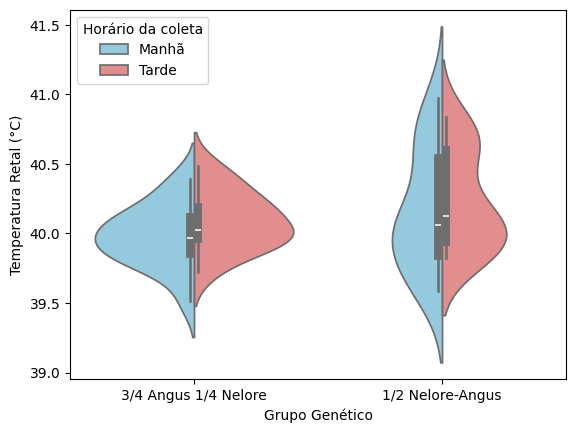

In [ ]:
#%% Gráfico de violino demonstrando diferença de temperatura
df_longo = pd.melt(df_grafico,
                  id_vars=['ds_grupo'],
                  value_vars=['temperatura_retal_1', 'temperatura_retal_2'],
                  var_name='tipo_temperatura',
                  value_name='temperatura_retal')

df_longo['tipo_temperatura'] = df_longo['tipo_temperatura'].replace({"temperatura_retal_1": "Manhã", "temperatura_retal_2": "Tarde"})
df_longo = df_longo.rename(columns={'tipo_temperatura': 'Horário da coleta'})

# Criar o gráfico de violino
sns.violinplot(x='ds_grupo', y='temperatura_retal', hue='Horário da coleta', data=df_longo, palette=['skyblue', 'lightcoral'], split=True)

# Adicionar título e rótulos
#plt.title('Gráfico de Violino das temperaturas por Grupo')
plt.xlabel('Grupo Genético')
plt.ylabel('Temperatura Retal (°C)')

###Pelagem

<ipython-input-23-06414f9372dd>:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




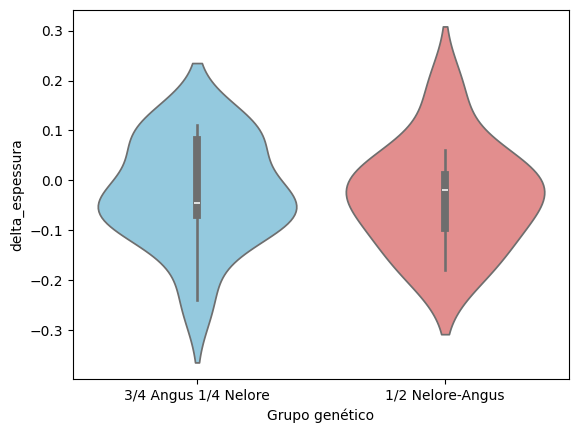

<ipython-input-23-06414f9372dd>:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




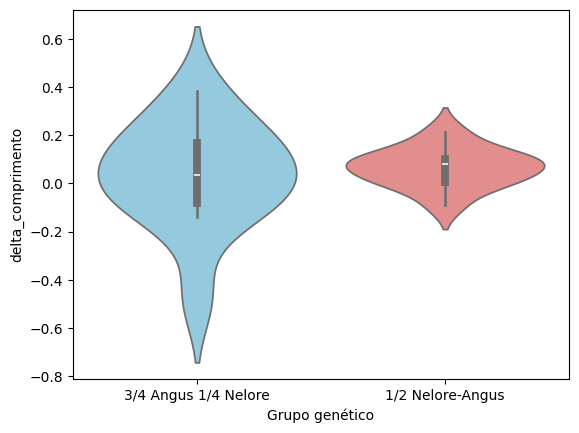

<ipython-input-23-06414f9372dd>:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




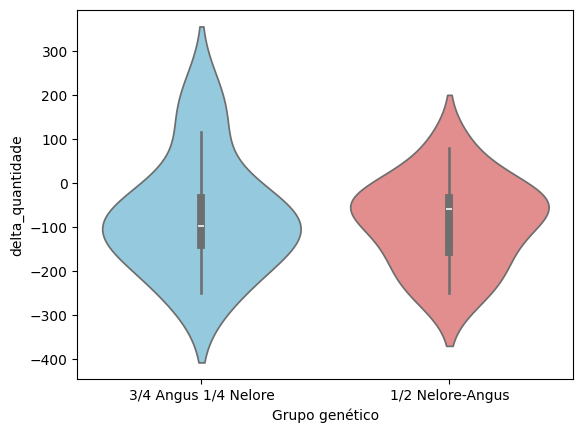

<ipython-input-23-06414f9372dd>:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




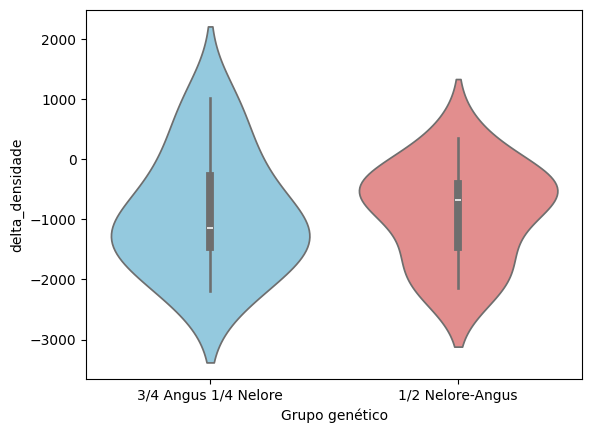

In [ ]:
for variavel in variaveis_pelo:
    plt.figure()  # Cria uma nova figura para cada gráfico (importante!)
    sns.violinplot(x='ds_grupo', y=variavel, data=df_pivot_pelo, palette=['skyblue', 'lightcoral'], split=False)
 #   plt.title(f'Gráfico de Violino para {variavel}')
    plt.ylabel(f'{variavel}')
    plt.xlabel('Grupo genético')
    plt.show()

# **Análise de Correlação de Pearson**


---


Relações entre as variáveis morfofisiológicas (temperatura x capa). Considerando as características do indivíduo maduro (final do experimento) com a variação de temperatura ao longo o dia.

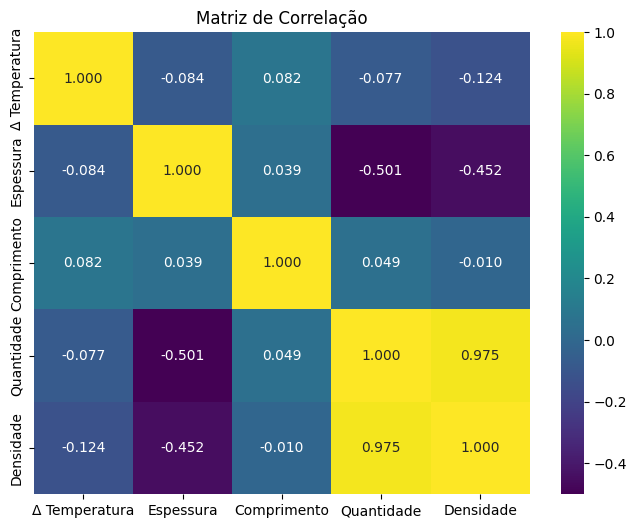

In [ ]:
correl = df[['delta_temp', 'espessura_4', 'comprimento_4', 'quantidade_4', 'densidade_4']]
# Renomeando as variáveis para ficar bonitinho na imagem
correl.columns = ['Δ Temperatura', 'Espessura', 'Comprimento', 'Quantidade', 'Densidade']

# Calculo da correlação
corr_matrix = correl.corr()

# Colocando a correlação num mapa de calor
plt.figure(figsize=(8, 6))  # Adjust figure size as needed
sns.heatmap(corr_matrix, annot=True, cmap='viridis', fmt=".3f")
plt.title('Matriz de Correlação')
plt.show()

# **Regressão logística**


---



O objetivo deste modelo é classificar os indivíduos em dois grupos genéticos distintos com base em suas características morfofisiológicas.

O sucesso da classificação indicaria que as características dos animais apresentam diferenças significativas, permitindo a distinção eficaz entre os grupos genéticos.

Para isso, foi aplicada a regressão logística binária, que utiliza a função de verossimilhança calculada por máxima verossimilhança. Este modelo foi escolhido por ser adequado para variáveis dicotômicas e por aderir à distribuição de Bernoulli, que descreve a probabilidade de ocorrência de um dos dois possíveis resultados.

In [ ]:
# Estimando o modelo de regressão múltipla por OLS
variaveis_independentes = ['delta_temp','espessura_4','comprimento_4','quantidade_4','densidade_4']
variavel_dependente = 'Grupo' # Variável dependente
formula = f"{variavel_dependente} ~ " + " + ".join(variaveis_independentes)

# Normalizar as variáveis (Z-score)
df2=df
variaveis_para_normalizar = ['delta_temp','espessura_4','comprimento_4','quantidade_4','densidade_4']
scaler = StandardScaler()
df2[variaveis_para_normalizar] = scaler.fit_transform(df2[variaveis_para_normalizar].values)

# Modelo inicial
modelo_reg_log= smf.glm(formula=formula, data=df2,
                         family=sm.families.Binomial()).fit()
modelo_reg_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Grupo   No. Observations:                   23
Model:                            GLM   Df Residuals:                       17
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -12.286
Date:                Mon, 21 Apr 2025   Deviance:                       24.571
Time:                        18:22:34   Pearson chi2:                     20.0
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2710
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.2323      0.519     -0.448      0.654      -1.249       0.784
delta_temp        0.3939      0.559      0.705      0.481      -0.701       1.489
espessura_4      -0.5638      0.587     -0.961      0.337      -1.714       0.586
comprimento_4    -0.7002      0.538     -1.302      0.193      -1.754       0.354
quantidade_4     -2.2145      2.475     -0.895      0.371      -7.065       2.636
densidade_4       0.6311      2.340      0.270      0.787      -3.955       5.217
=================================================================================
"""

Os coeficientes β das variáveis não foram significativos no modelo (P > 0,05). Dessa forma, podemos aplicar o método stepwise, que irá testar diferentes combinações das variáveis, visando identificar a melhor configuração para o nosso modelo.

In [ ]:

# Algumas variáveis não passaram, vamos para o stepwise
modelo_stepwise = stepwise(modelo_reg_log, pvalue_limit=0.05)
modelo_stepwise.summary()

Regression type: GLM 

Estimating model...: 
 Grupo ~ Q('delta_temp') + Q('espessura_4') + Q('comprimento_4') + Q('quantidade_4') + Q('densidade_4')

 Family type...: 
 Binomial

 Discarding atribute "Q('densidade_4')" with p-value equal to 0.7873663805920851 

Estimating model...: 
 Grupo ~ Q('delta_temp') + Q('espessura_4') + Q('comprimento_4') + Q('quantidade_4')

 Family type...: 
 Binomial

 Discarding atribute "Q('delta_temp')" with p-value equal to 0.5004285403055615 

Estimating model...: 
 Grupo ~ Q('espessura_4') + Q('comprimento_4') + Q('quantidade_4')

 Family type...: 
 Binomial

 Discarding atribute "Q('espessura_4')" with p-value equal to 0.333638170385231 

Estimating model...: 
 Grupo ~ Q('comprimento_4') + Q('quantidade_4')

 Family type...: 
 Binomial

 Discarding atribute "Q('comprimento_4')" with p-value equal to 0.18028335319564714 

Estimating model...: 
 Grupo ~ Q('quantidade_4')

 Family type...: 
 Binomial

 Discarding atribute "Q('quantidade_4')" with p-value

PatsyError: expected a noun, but instead the expression ended
    Grupo ~
          ^

O modelo foi reduzido a um ponto em que nenhuma variável foi mantida após o processo de stepwise, resultando em uma fórmula vazia para o modelo (Grupo ~). Isso faz com que o código não consiga estimar um modelo válido, pois ele espera pelo menos uma variável para construir a equação. Entendemos assim que com essas variáveis não temos modelo, reforçando os resultados anteriores que indicam a similaridade entre os grupos genéticos.

# **Análise fatorial**


---

Para essa análise tentaremos diminuir a dimensionalidade considerando características do ambiente e dos animais ao longo em diferentes tempos de coleta.


### Transformando os dados

Para identificar agrupamentos de variáveis que possam representar características comuns, não iremos consolidar a base por animal, para preservar variabilidade individual das amostras.

In [ ]:
## Base de temperatura
base_temp = pd.read_csv("base_temperatura.csv", sep=";", decimal=",")

#Retirando ultima coluna de comentário
base_temp = base_temp.drop('Unnamed: 10', axis=1)

#Alterando formato do campo data_coleta
base_temp['data_coleta'] = pd.to_datetime(base_temp['data_coleta'], format='%d/%m/%Y')

## Base pelame
base_pelame = pd.read_csv("base_pelame.csv", sep=";", decimal=",")

#Alterando formato do campo data_coleta
base_pelame['data_coleta'] = pd.to_datetime(base_pelame['data_coleta'], format='%d/%m/%Y')

#Juntando as bases de temperatura e pelame
base_completa = pd.merge(base_temp, base_pelame, on=['data_coleta', 'animal', 'grupo_gen'], how='inner')

#Removendo linhas que têm valor ausente, colunas desnecessárias e adicionando grupo+animal
base_completa = base_completa.dropna()

dummies_grupo = pd.get_dummies(base_completa['grupo_gen'], prefix='grupo', dtype=int, drop_first=True)
dummies_horariocoleta = pd.get_dummies(base_completa['horario_coleta'], prefix='horario',dtype=int, drop_first=True)

base_completa = pd.concat([base_completa, dummies_grupo], axis=1)
base_completa = pd.concat([base_completa, dummies_horariocoleta], axis=1)

base_completa['animal_gen'] = base_completa['animal'].astype(str) + '_' + base_completa['grupo_gen'].astype(str)
colunas_para_remover = ['temperatura_ambiente_k','repeticao_y','grupo_gen','horario_coleta']
base_completa = base_completa.drop(columns=colunas_para_remover)

#Renomeando colunas
base_completa.columns = ['DtSamp','Anim','Samp','RT', 'AT', 'RTL', 'RH','Thk', 'Len', 'Qty', 'Ar', 'Dens', 'Gen', 'Per', 'AniGen']
base_completa.info()

<class 'pandas.core.frame.DataFrame'>
Index: 212 entries, 0 to 239
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DtSamp  212 non-null    datetime64[ns]
 1   Anim    212 non-null    int64         
 2   Samp    212 non-null    int64         
 3   RT      212 non-null    float64       
 4   AT      212 non-null    float64       
 5   RTL     212 non-null    float64       
 6   RH      212 non-null    float64       
 7   Thk     212 non-null    float64       
 8   Len     212 non-null    float64       
 9   Qty     212 non-null    float64       
 10  Ar      212 non-null    float64       
 11  Dens    212 non-null    float64       
 12  Gen     212 non-null    int64         
 13  Per     212 non-null    int64         
 14  AniGen  212 non-null    object        
dtypes: datetime64[ns](1), float64(9), int64(4), object(1)
memory usage: 26.5+ KB


Data coleta: Data Sampling (DtSamp)

Coleta: Sampling (Samp)

Animal: Animal (Anim)

Genótipo: Genotype (Gen)

Horário: Period (Per)

Temperatura Retal: Rectal Temperature (RT)

Temperatura Ambiente: Ambient Temperature (AT)

Carga Térmica Radiante: Radiant Thermal Load (RTL)

Umidade Relativa: Relative Humidity (RH)

Espessura: Thickness (Thk)


Comprimento: Length (Len)

Quantidade: Quantity (Qty)

Área: Area (Ar)

Densidade: Density (Dens)

animal+grupo: AniGen - dummy

In [ ]:
base_completa.head(5)

,DtSamp,Anim,Samp,RT,AT,RTL,RH,Thk,Len,Qty,Ar,Dens,Gen,Per,AniGen
0,2007-01-03,1,5,39.5,25.3,576.679282,70.945268,0.35,1.189,381.0,0.12065,3157.894737,0,0,1_1
1,2007-01-03,1,5,40.1,28.3,601.523559,57.785924,0.35,1.189,381.0,0.12065,3157.894737,0,1,1_1
2,2007-01-03,2,5,39.9,25.3,576.679282,70.945268,0.28,0.751,178.0,0.12065,1475.341898,0,0,2_1
3,2007-01-03,2,5,40.2,28.3,601.523559,57.785924,0.28,0.751,178.0,0.12065,1475.341898,0,1,2_1
4,2007-01-03,3,5,39.7,25.3,576.679282,70.945268,0.30,1.147,409.0,0.12065,3389.970990,0,0,3_1


In [ ]:
# Calcular a correlação entre AT e RTL
correlacao = base_completa['AT'].corr(base_completa['RTL'])
print(f"Correlação entre AT e RTL: {correlacao}")

Correlação entre AT e RTL: -0.6167940739462837


Correlação moderada negativa. Executando uma análise fatorial inicial com ambas as variáveis presentes vemos que se fazem presente de maneira oposta em dois fatores, mas não possuem peso nos demais. Como a variável RTL possui contribui de maneira significativa apenas para o fator 1, dentre as duas vamos manter apenas a AT para representar a característica ambiental.

Foi criado inicialmente um modelo mantendo as dummies que especificam o momento da coleta, para acompanharmos o impacto da variação temporal nas características avaliadas diante da possibilidade de alterações fisiológicas ao longo do tempo. Entretanto a presença dessas variáveis apresentou pouca contribuição para explicação dos dados. Por esse motivo optou-se por retira-las da análise.

Foram mantidos na base de dados os pontos de coleta em que se tem informações simultânea de pelagem e temperatura, para que fosse possível tentar enxergar uma associação.

In [ ]:
#Criando dummies para repeticao - Sampling (equivale a data_coleta)
#dummies_repeticao = pd.get_dummies(base_completa['Samp'], prefix='Samp', dtype=int, drop_first=True)
#base_FA = pd.concat([base_completa, dummies_repeticao], axis=1)

base_FA = base_completa

#Retirando variáveis, incluindo 'Gen' que usaremos para comparar por correlação pelo ranking
colunas_para_remover = ['DtSamp','Anim','AniGen','Gen','Samp','Ar','RTL']
base_FA = base_FA.drop(columns=colunas_para_remover)

#Normalizar as variáveis (Z-score)
variaveis_para_normalizar =  ['RT', 'AT', 'RH','Thk', 'Len', 'Qty', 'Dens']
scaler = StandardScaler()
base_FA[variaveis_para_normalizar] = scaler.fit_transform(base_FA[variaveis_para_normalizar])
base_FA.info()

<class 'pandas.core.frame.DataFrame'>
Index: 212 entries, 0 to 239
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RT      212 non-null    float64
 1   AT      212 non-null    float64
 2   RH      212 non-null    float64
 3   Thk     212 non-null    float64
 4   Len     212 non-null    float64
 5   Qty     212 non-null    float64
 6   Dens    212 non-null    float64
 7   Per     212 non-null    int64  
dtypes: float64(7), int64(1)
memory usage: 14.9 KB


In [ ]:
#Verificando estrutura
base_FA.head(5)

,RT,AT,RH,Thk,Len,Qty,Dens,Per
0,-1.134535,-1.237843,0.340782,0.392436,1.424995,1.330754,1.359890,0
1,0.031158,0.339533,-1.819457,0.392436,1.424995,1.330754,1.359890,1
2,-0.357406,-1.237843,0.340782,-0.678107,-0.796171,-0.798413,-0.713129,0
3,0.225441,0.339533,-1.819457,-0.678107,-0.796171,-0.798413,-0.713129,1
4,-0.745971,-1.237843,0.340782,-0.372237,1.212006,1.624432,1.645823,0


### Teste de Esfericidade de Bartlett
Verificando se o conjunto de dados está suficientemente correlacionadas para justificar a aplicação de técnicas de redução de dimensionalidade.

In [ ]:
bartlett, p_value = calculate_bartlett_sphericity(base_FA)
print(f'Qui² Bartlett: {round(bartlett, 2)}')
print(f'p-valor: {round(p_value, 4)}')

Qui² Bartlett: 905.12
p-valor: 0.0


In [ ]:
#Primeira análise - com o número de autovalores igual de variáveis
fa_v1 = FactorAnalyzer(n_factors=8, method='principal', rotation=None).fit(base_FA)
autovalores = fa_v1.get_eigenvalues()[0]

# Eigenvalues, variâncias e variâncias acumuladas
autovalores_fatores = fa_v1.get_factor_variance()
tabela_eigen = pd.DataFrame(autovalores_fatores)
tabela_eigen.columns = [f"Fator {i+1}" for i, v in enumerate(tabela_eigen.columns)]
tabela_eigen.index = ['Autovalor','Variância', 'Variância Acumulada']
tabela_eigen = tabela_eigen.T

# Critério de Kaiser (raiz latente)
print(tabela_eigen)

         Autovalor  Variância  Variância Acumulada
Fator 1   2.215728   0.276966             0.276966
Fator 2   1.298105   0.162263             0.439229
Fator 3   1.203347   0.150418             0.589648
Fator 4   1.147229   0.143404             0.733051
Fator 5   0.872515   0.109064             0.842116
Fator 6   0.761056   0.095132             0.937248
Fator 7   0.492192   0.061524             0.998772
Fator 8   0.009827   0.001228             1.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



4 autovalores são maiores que 1 (satisfazem o Critério de Kaiser)




### Análise final com os autovetores aprovados (>1)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



         Autovalor  Variância  Variância Acumulada
Fator 1   2.215728   0.276966             0.276966
Fator 2   1.298105   0.162263             0.439229
Fator 3   1.203347   0.150418             0.589648
Fator 4   1.147229   0.143404             0.733051


<ipython-input-226-a9025ff38236>:14: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




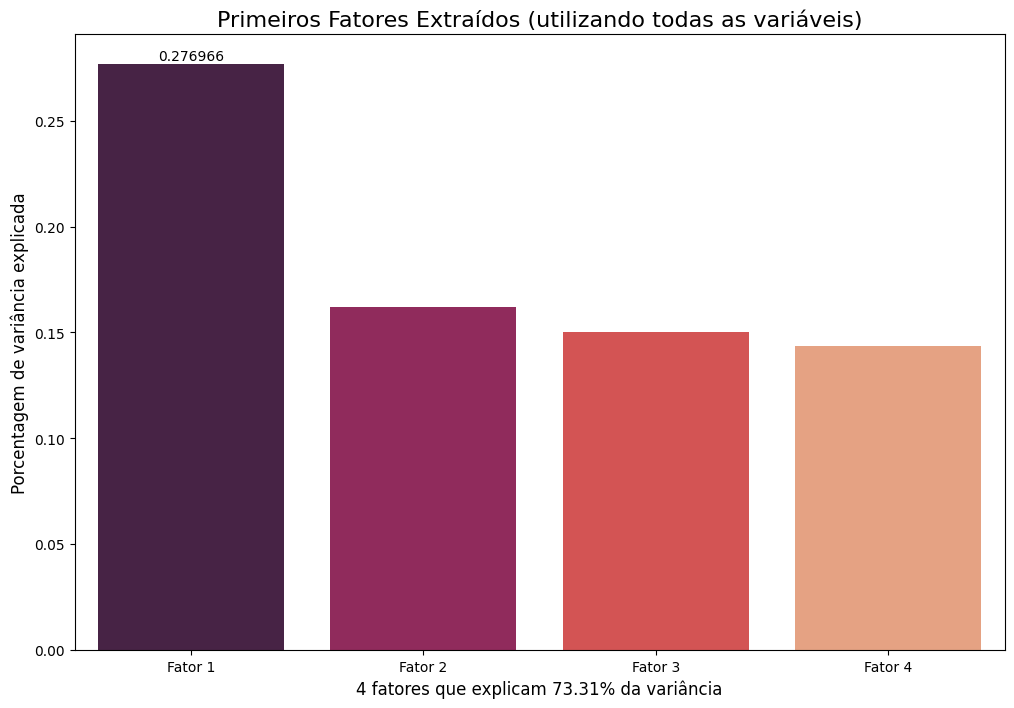

In [ ]:
#Segunda análise - com a quantidade de autovetores maiores que 1
fa = FactorAnalyzer(n_factors=4, method='principal', rotation=None).fit(base_FA)

# Eigenvalues, variâncias e variâncias acumuladas
autovalores_fatores = fa.get_factor_variance()
tabela_eigen = pd.DataFrame(autovalores_fatores)
tabela_eigen.columns = [f"Fator {i+1}" for i, v in enumerate(tabela_eigen.columns)]
tabela_eigen.index = ['Autovalor','Variância', 'Variância Acumulada']
tabela_eigen = tabela_eigen.T
print(tabela_eigen)

# Gráfico de barras demonstrando a variância
plt.figure(figsize=(12,8))
ax = sns.barplot(x=tabela_eigen.index, y=tabela_eigen['Variância'], data=tabela_eigen, palette='rocket')
ax.bar_label(ax.containers[0])
plt.title("Primeiros Fatores Extraídos (utilizando todas as variáveis)", fontsize=16)
plt.xlabel(f"{tabela_eigen.shape[0]} fatores que explicam {round(tabela_eigen['Variância'].sum()*100,2)}% da variância", fontsize=12)
plt.ylabel("Porcentagem de variância explicada", fontsize=12)
plt.show()

Os fatores que satisfazem o critério de Kaiser explicam 73% da variância, isso indica uma boa capacidade de representação da estrutura original das variáveis.



In [ ]:
# Determinando as cargas fatoriais
cargas_fatoriais = fa.loadings_

tabela_cargas = pd.DataFrame(cargas_fatoriais)
tabela_cargas.columns = [f"Fator {i+1}" for i, v in enumerate(tabela_cargas.columns)]
tabela_cargas.index = base_FA.columns
print(tabela_cargas)

       Fator 1   Fator 2   Fator 3   Fator 4
RT    0.128747  0.395079  0.579101 -0.356232
AT   -0.459966  0.397340  0.230794 -0.155577
RH    0.076127 -0.393355  0.727241 -0.345308
Thk   0.389301  0.063613  0.292275  0.581825
Len  -0.007480  0.185436  0.414597  0.708829
Qty   0.945750  0.113680 -0.087966 -0.124557
Dens  0.963641  0.108824 -0.064485 -0.114214
Per  -0.084442  0.875335 -0.128965 -0.085838


Cargas fatoriais = grau de correlação, quanto mais próxima de 1 (ou -1), mais forte é a relação da variável com o fator, próximas de 0 indicam baixa associação da variável com o fator.

**Fator 1:** Forte associação positiva com densidade e quantidade (*características físicas e estruturais*).

**Fator 2:** Fortemente associado a período e moderadamente associado a temperatura ambiental e temperatura retal (*relação com condições ambientais e fisiológicas*).

**Fator 3:** Fortemente associado com temperatura retal e umidade relativa - temperatura corporal e a umidade estão relacionadas - e possui associação moderada com comprimento (*fisiologia e condições ambientais*).

**Fator 4:** Associação positiva a comprimento e espessura (*características físicas estruturais*).

In [ ]:
# Determinando as comunalidades
comunalidades = fa.get_communalities()
tabela_comunalidades = pd.DataFrame(comunalidades)
tabela_comunalidades.columns = ['Comunalidades']
tabela_comunalidades.index = base_FA.columns
print(tabela_comunalidades)

      Comunalidades
RT         0.634922
AT         0.446918
RH         0.808641
Thk        0.579547
Len        0.708771
Qty        0.930619
Dens       0.957649
Per        0.797342


Comunalidade permite entender quanto cada fator contribui para a variável. Nossos fatores gerados capturam principalmente as informações das variáveis: Umidade relativa (RH), Comprimento (Len), Quantidade (Qty), Densidade (Dens) e Período (Per).

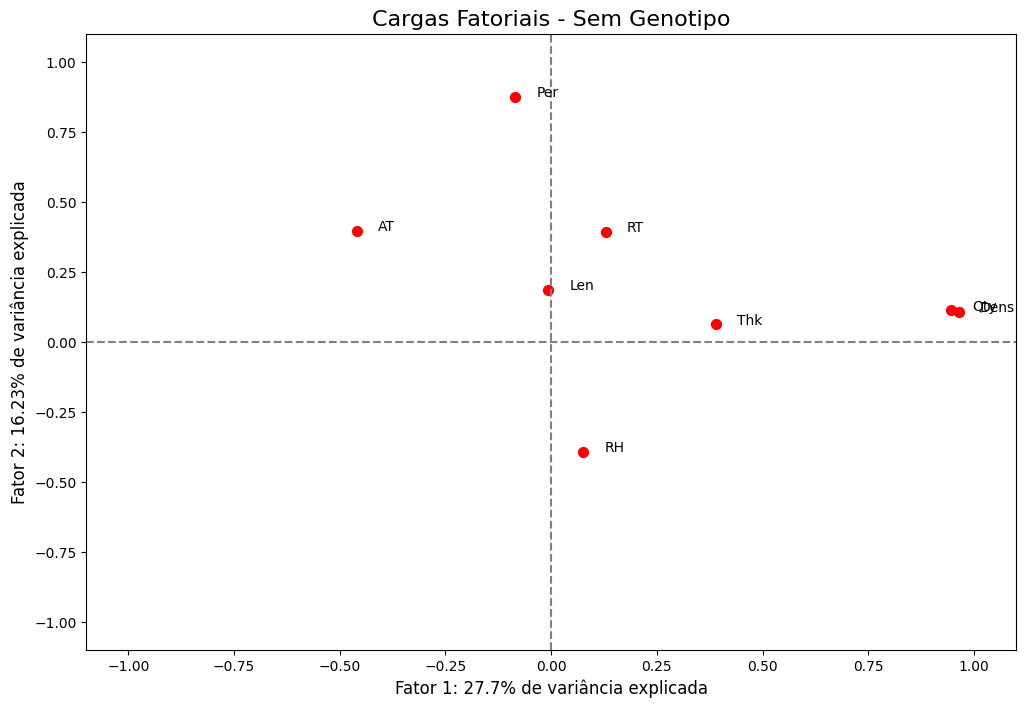

In [ ]:
#Grafico de carga fatorial
plt.figure(figsize=(12,8))
tabela_cargas_chart = tabela_cargas.reset_index()
plt.scatter(tabela_cargas_chart['Fator 1'], tabela_cargas_chart['Fator 2'], s=50, color='red')

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'] + 0.05, point['y'], point['val'])

label_point(x = tabela_cargas_chart['Fator 1'],
            y = tabela_cargas_chart['Fator 2'],
            val = tabela_cargas_chart['index'],
            ax = plt.gca())

plt.axhline(y=0, color='grey', ls='--')
plt.axvline(x=0, color='grey', ls='--')
plt.ylim([-1.1,1.1])
plt.xlim([-1.1,1.1])
plt.title("Cargas Fatoriais - Sem Genotipo", fontsize=16)
plt.xlabel(f"Fator 1: {round(tabela_eigen.iloc[0]['Variância']*100,2)}% de variância explicada", fontsize=12)
plt.ylabel(f"Fator 2: {round(tabela_eigen.iloc[1]['Variância']*100,2)}% de variância explicada", fontsize=12)
plt.show()

Considerando que:

**Fator 1:** *características físicas e estruturais*.

**Fator 2:** *relação com condições ambientais e fisiológicas*.

> No primeiro quadrante: Densidade, quantidade e espessura da pelagem apresentam relação positiva com fator 1 e 2, assim como temperatura retal. Sugere a relação do desenvolvimento dos traços morfologicos (pelagem) com os fatores ambientais e a associação da pelagem na regulação térmica.

> No segundo quadrante temos a temperatura ambiental, apresenta carga positivo no fator 2 (condição ambiental) e carga negativa fraca em relação ao fator 1 (característica animal). A posição isolada sugere que ela captura um aspecto único do ambiente térmico.
> A umidade relativa tem carga negativa no Fator 2, indicando que ela está inversamente relacionada às condições ambientais capturadas por este fator (temperatura ambiental).



In [ ]:
#Criando um ranking considerando os 4 fatores com autovalores > 1

# Extração dos fatores para as observações do banco de dados
fatores = pd.DataFrame(fa.transform(base_FA))
fatores.columns =  [f"Fator {i+1}" for i, v in enumerate(fatores.columns)]

# Adicionando os fatores ao banco de dados
base_FA_fatores = pd.concat([base_completa.reset_index(drop=True), fatores], axis=1)

base_FA_fatores['Ranking'] = 0

for index, item in enumerate(list(tabela_eigen.index)):
    variancia = tabela_eigen.loc[item]['Variância']

    base_FA_fatores['Ranking'] = base_FA_fatores['Ranking'] + base_FA_fatores[tabela_eigen.index[index]]*variancia

# Observando se a coluna com o ranking entrou na nossa base
base_FA_fatores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212 entries, 0 to 211
Data columns (total 20 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   DtSamp   212 non-null    datetime64[ns]
 1   Anim     212 non-null    int64         
 2   Samp     212 non-null    int64         
 3   RT       212 non-null    float64       
 4   AT       212 non-null    float64       
 5   RTL      212 non-null    float64       
 6   RH       212 non-null    float64       
 7   Thk      212 non-null    float64       
 8   Len      212 non-null    float64       
 9   Qty      212 non-null    float64       
 10  Ar       212 non-null    float64       
 11  Dens     212 non-null    float64       
 12  Gen      212 non-null    int64         
 13  Per      212 non-null    int64         
 14  AniGen   212 non-null    object        
 15  Fator 1  212 non-null    float64       
 16  Fator 2  212 non-null    float64       
 17  Fator 3  212 non-null    float64   

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



In [ ]:
# Os grupos genotipicos alinham-se às características representadas nos fatores?
correl_fa = pg.rcorr(base_FA_fatores[['Ranking', 'Gen']],
             method = 'pearson', upper = 'pval',
             decimals = 4,
             pval_stars = {0.01: '***', 0.05: '**', 0.10: '*'})

correl_fa.columns = ['Ranking','Genótipo']
correl_fa.index =  ['Ranking','Genótipo']
correl_fa

,Ranking,Genótipo
Ranking,-,**
Genótipo,-0.1724,-


Correlação negativa fraca (à medida que os valores do ranking aumentam, os valores do genótipo tendem a diminuir **ligeiramente**).

Consolidar base de fatores por animal

In [ ]:
# Mantendo apenas identificação do animal e os fatores, porém a média do fator por animal
fatores_consolidados = base_FA_fatores.groupby('AniGen').mean().reset_index()

# Criando um novo ranking
fatores_consolidados['Ranking'] = 0

# Iterar sobre os fatores e suas respectivas variâncias para calcular o ranking
for index, item in enumerate(list(tabela_eigen.index)):
 variancia = tabela_eigen.loc[item]['Variância']  # Pegar a variância explicada do fator
 fatores_consolidados['Ranking'] += fatores_consolidados[f"Fator {index+1}"] * variancia

fatores_consolidados =fatores_consolidados[['AniGen', 'Gen', 'Fator 1', 'Fator 2','Fator 3','Fator 4', 'Ranking']]
fatores_consolidados['Gen'] = fatores_consolidados['Gen'].astype(int)

# Observando se a coluna com o ranking entrou na nova base consolidada
fatores_consolidados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   AniGen   30 non-null     object 
 1   Gen      30 non-null     int64  
 2   Fator 1  30 non-null     float64
 3   Fator 2  30 non-null     float64
 4   Fator 3  30 non-null     float64
 5   Fator 4  30 non-null     float64
 6   Ranking  30 non-null     float64
dtypes: float64(5), int64(1), object(1)
memory usage: 1.8+ KB


### Correlação de Pearson a partir do ranking (dos fatores) da tabela consolidada


In [ ]:
# Nova análise de correlação de Pearson a partir do ranking da tabela consolidada
correl_fa = pg.rcorr(fatores_consolidados[['Ranking', 'Gen']],
             method = 'pearson', upper = 'pval',
             decimals = 4,
             pval_stars = {0.01: '***', 0.05: '**', 0.10: '*'})

correl_fa.columns = ['Ranking','Genótipo']
correl_fa.index =  ['Ranking','Genótipo']
correl_fa

,Ranking,Genótipo
Ranking,-,
Genótipo,-0.2921,-


Segue sendo uma correlação negativa fraca (à medida que os valores do ranking aumentam, os valores do genótipo tendem a diminuir **ligeiramente**).

#Análise de regressão logística


---



##Regressão utilizando as variáveis

In [ ]:
base_RL = base_completa

#Mantendo variáveis ambientais, temperatura do animal e pelame, assim como o grupo que queremos analisar
colunas_para_remover = ['DtSamp','Anim','AniGen','Samp','RTL','Ar']
base_RL = base_RL.drop(columns=colunas_para_remover)
base_RL.info()

<class 'pandas.core.frame.DataFrame'>
Index: 212 entries, 0 to 239
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RT      212 non-null    float64
 1   AT      212 non-null    float64
 2   RH      212 non-null    float64
 3   Thk     212 non-null    float64
 4   Len     212 non-null    float64
 5   Qty     212 non-null    float64
 6   Dens    212 non-null    float64
 7   Gen     212 non-null    int64  
 8   Per     212 non-null    int64  
dtypes: float64(7), int64(2)
memory usage: 16.6 KB


In [ ]:
#Normalizar as variáveis (Z-score)
variaveis_para_normalizar = ['RT', 'AT', 'RH','Thk', 'Len', 'Qty', 'Dens']
scaler = StandardScaler()
base_RL[variaveis_para_normalizar] = scaler.fit_transform(base_RL[variaveis_para_normalizar])

modelo_genotipo = smf.glm(formula='Gen ~ RT + AT + RH + Thk + Len + Qty + Dens + Per', data=base_RL,
                         family=sm.families.Binomial()).fit()
modelo_genotipo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    Gen   No. Observations:                  212
Model:                            GLM   Df Residuals:                      203
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -132.78
Date:                Mon, 21 Apr 2025   Deviance:                       265.57
Time:                        00:51:24   Pearson chi2:                     208.
No. Iterations:                     4   Pseudo R-squ. (CS):             0.1251
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0723      0.219      0.330      0.741      -0.357       0.501
RT             0.3643      0.164      2.222      0.026       0.043       0.686
AT            -0.0298      0.162     -0.184      0.854      -0.347       0.287
RH            -0.0938      0.159     -0.590      0.555      -0.405       0.218
Thk           -0.1045      0.168     -0.622      0.534      -0.434       0.225
Len           -0.6132      0.172     -3.574      0.000      -0.949      -0.277
Qty           -1.7282      1.092     -1.583      0.113      -3.868       0.411
Dens           1.4749      1.115      1.323      0.186      -0.710       3.659
Per           -0.1668      0.324     -0.515      0.607      -0.802       0.468
==============================================================================
"""

In [ ]:
#Algumas variáveis não passaram, vamos para o stepwise
modelo_stepwise = stepwise(modelo_genotipo, pvalue_limit=0.05)
modelo_stepwise.summary()

Regression type: GLM 

Estimating model...: 
 Gen ~ Q('RT') + Q('AT') + Q('RH') + Q('Thk') + Q('Len') + Q('Qty') + Q('Dens') + Q('Per')

 Family type...: 
 Binomial

 Discarding atribute "Q('AT')" with p-value equal to 0.8538757327646107 

Estimating model...: 
 Gen ~ Q('RT') + Q('RH') + Q('Thk') + Q('Len') + Q('Qty') + Q('Dens') + Q('Per')

 Family type...: 
 Binomial

 Discarding atribute "Q('Per')" with p-value equal to 0.5577209600351283 

Estimating model...: 
 Gen ~ Q('RT') + Q('RH') + Q('Thk') + Q('Len') + Q('Qty') + Q('Dens')

 Family type...: 
 Binomial

 Discarding atribute "Q('RH')" with p-value equal to 0.6247107106132418 

Estimating model...: 
 Gen ~ Q('RT') + Q('Thk') + Q('Len') + Q('Qty') + Q('Dens')

 Family type...: 
 Binomial

 Discarding atribute "Q('Thk')" with p-value equal to 0.5127358169449717 

Estimating model...: 
 Gen ~ Q('RT') + Q('Len') + Q('Qty') + Q('Dens')

 Family type...: 
 Binomial

 Discarding atribute "Q('Dens')" with p-value equal to 0.22003690862

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    Gen   No. Observations:                  212
Model:                            GLM   Df Residuals:                      209
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -136.00
Date:                Mon, 21 Apr 2025   Deviance:                       272.00
Time:                        00:51:51   Pearson chi2:                     208.
No. Iterations:                     4   Pseudo R-squ. (CS):            0.09811
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0101      0.145     -0.070      0.945      -0.294       0.274
Q('RT')        0.3434      0.151      2.267      0.023       0.047       0.640
Q('Len')      -0.6414      0.165     -3.891      0.000      -0.964      -0.318
==============================================================================
"""

Modelo construído utilizando comprimento e temperatura retal.


In [ ]:
OD_INT = round(np.exp(-0.0101), 4)
OD_RT = round(np.exp(0.3434), 4)
OD_LEN = round(np.exp(-0.6414), 4)

print("Razão de chance")
print("Intercepto:", OD_INT)
print("Temperatura Retal:", OD_RT)
print("Comprimento:", OD_LEN)

Razão de chance
Intercepto: 0.99
Temperatura Retal: 1.4097
Comprimento: 0.5266



**Odds Ratio (Razão de chance) = e^(coeficiente)**

>( OR > 1 ): A variável aumenta as chances do evento.

>( OR < 1 ): A variável reduz as chances do evento.

>( OR = 1 ): A variável não altera as chances do evento.

In [ ]:
# Intervalos de confiança dos coeficientes
intervalos_coeficientes = {
 "Intercepto": [-0.294, 0.274],
 "Q('RT')": [0.047, 0.640],
 "Q('Len')": [-0.964, -0.318]
}

#  Intervalo de confiança do odds ratio
intervalos_odds_ratio = {var: [np.exp(lim[0]), np.exp(lim[1])] for var, lim in intervalos_coeficientes.items()}
for var, ic_or in intervalos_odds_ratio.items():
 print(f"{var}: Odds Ratio IC95% = [{ic_or[0]:.3f}, {ic_or[1]:.3f}]")

Intercepto: Odds Ratio IC95% = [0.745, 1.315]
Q('RT'): Odds Ratio IC95% = [1.048, 1.896]
Q('Len'): Odds Ratio IC95% = [0.381, 0.728]


Intervalo de Confiança (IC) da Razão de Chance (OD)

Se o ICOD inclui 1 o efeito da variável é estatisticamente significativo. O intercepto e a temperatura retal incluem.
Se o ICOR não inclui 1 o efeito da variável pode ser insignificante. Comprimento não inclui.

###Curva ROC (Receiver Operating Characteristic)

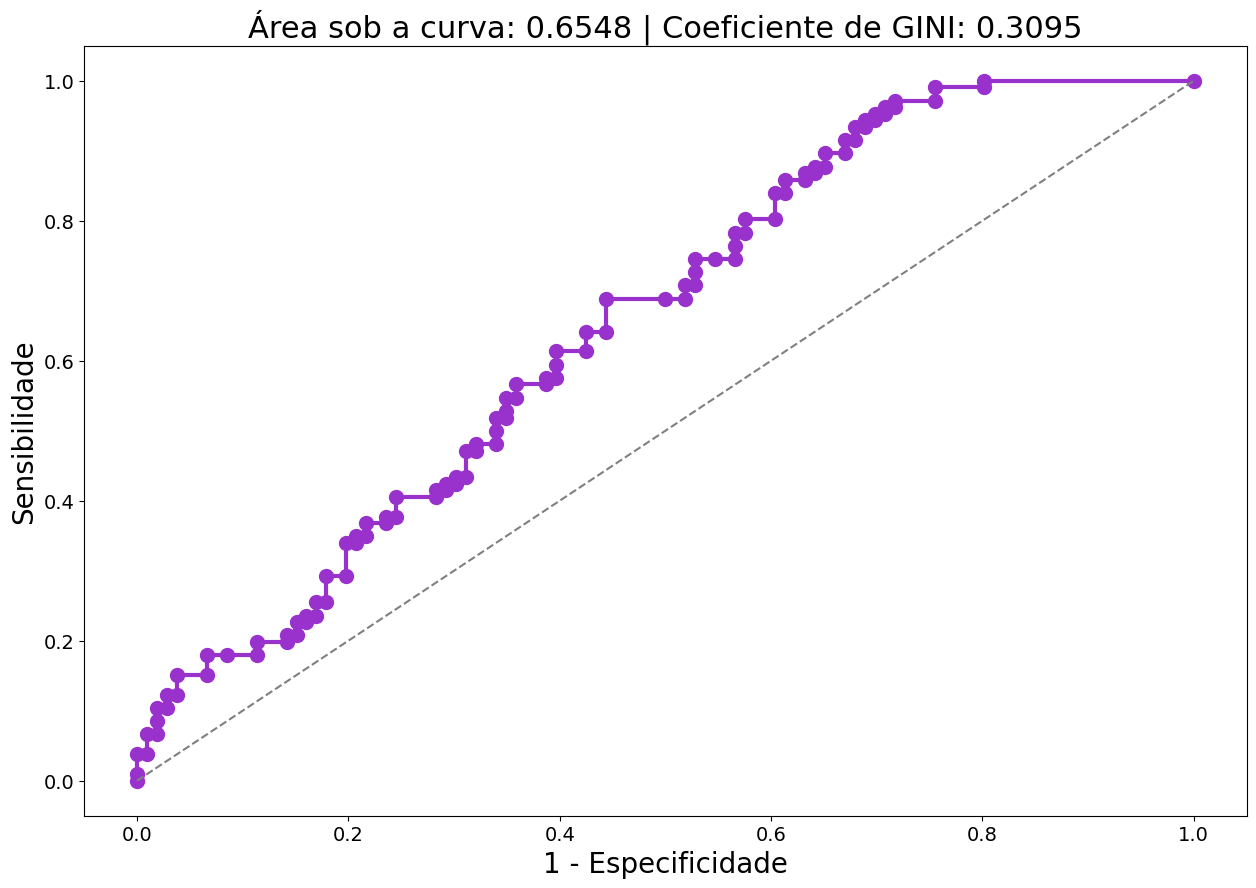

In [ ]:
# Probabilidade de ocorrência do evento (grupo = 1)
base_RL['previsto'] = modelo_stepwise.predict()

# Análise da curva ROC
# Parametrizando a função da curva ROC (real vs. previsto)
fpr, tpr, thresholds = roc_curve(base_RL['Gen'], base_RL['previsto'])
roc_auc = auc(fpr, tpr)

# Cálculo do coeficiente de GINI
gini = (roc_auc - 0.5)/(0.5)

# Plotando a curva ROC
plt.figure(figsize=(15,10))
plt.plot(fpr, tpr, marker='o', color='darkorchid', markersize=10, linewidth=3)
plt.plot(fpr, fpr, color='gray', linestyle='dashed')
plt.title('Área sob a curva: %g' % round(roc_auc, 4) +
          ' | Coeficiente de GINI: %g' % round(gini, 4), fontsize=22)
plt.xlabel('1 - Especificidade', fontsize=20)
plt.ylabel('Sensibilidade', fontsize=20)
plt.xticks(np.arange(0, 1.1, 0.2), fontsize=14)
plt.yticks(np.arange(0, 1.1, 0.2), fontsize=14)
plt.show()


ROC 0.6548 -> baixa capacidade preditiva

###Matriz de confusão

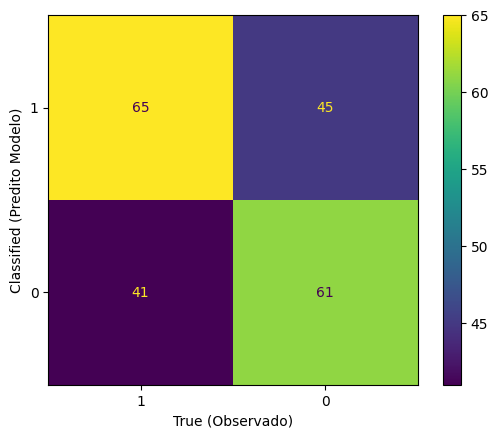

,Sensitividade,Especificidade,Acurácia
0,0.613208,0.575472,0.59434


In [ ]:
# Matriz de confusão (definição da função)
def matriz_confusao(predicts, observado, cutoff):
    values = predicts.values
    predicao_binaria = []
    for item in values:
        if item < cutoff:
            predicao_binaria.append(0)
        else:
            predicao_binaria.append(1)

    cm = confusion_matrix(predicao_binaria, observado)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.xlabel('True (Observado)')
    plt.ylabel('Classified (Predito Modelo)')
    plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()
    plt.show()

    sensitividade = recall_score(observado, predicao_binaria, pos_label=1)
    especificidade = recall_score(observado, predicao_binaria, pos_label=0)
    acuracia = accuracy_score(observado, predicao_binaria)

    #Visualizando os principais indicadores desta matriz de confusão
    indicadores = pd.DataFrame({'Sensitividade':[sensitividade],
                                'Especificidade':[especificidade],
                                'Acurácia':[acuracia]})
    return indicadores

# Matriz de confusão
# Cutoff = 0.50
matriz_confusao(observado=base_RL['Gen'],
                predicts=base_RL['previsto'],
                cutoff=0.50)

## Regressão utilizando os fatores

In [ ]:
colunas_para_manter = ['Fator 1', 'Fator 2', 'Fator 3', 'Fator 4', 'Gen']
base_RL_fatores = base_FA_fatores.loc[:, colunas_para_manter]
base_RL_fatores.columns = ['Fator_1', 'Fator_2', 'Fator_3', 'Fator_4', 'Gen']

modelo_gen_fat= smf.glm(formula='Gen ~ Fator_1 + Fator_2 + Fator_3 + Fator_4', data=base_RL_fatores,
                         family=sm.families.Binomial()).fit()
modelo_gen_fat.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    Gen   No. Observations:                  212
Model:                            GLM   Df Residuals:                      207
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -140.08
Date:                Mon, 21 Apr 2025   Deviance:                       280.15
Time:                        18:23:06   Pearson chi2:                     210.
No. Iterations:                     4   Pseudo R-squ. (CS):            0.06277
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0062      0.142     -0.043      0.965      -0.284       0.272
Fator_1       -0.1757      0.143     -1.226      0.220      -0.457       0.105
Fator_2       -0.0561      0.142     -0.394      0.693      -0.335       0.223
Fator_3       -0.0822      0.143     -0.575      0.566      -0.362       0.198
Fator_4       -0.4970      0.151     -3.295      0.001      -0.793      -0.201
==============================================================================
"""

In [ ]:
#Algumas variáveis não passou, vamos para o stepwise
modelo_stepwise = stepwise(modelo_gen_fat, pvalue_limit=0.05)
modelo_stepwise.summary()

Regression type: GLM 

Estimating model...: 
 Gen ~ Q('Fator_1') + Q('Fator_2') + Q('Fator_3') + Q('Fator_4')

 Family type...: 
 Binomial

 Discarding atribute "Q('Fator_2')" with p-value equal to 0.6932822393362154 

Estimating model...: 
 Gen ~ Q('Fator_1') + Q('Fator_3') + Q('Fator_4')

 Family type...: 
 Binomial

 Discarding atribute "Q('Fator_3')" with p-value equal to 0.5647381324679229 

Estimating model...: 
 Gen ~ Q('Fator_1') + Q('Fator_4')

 Family type...: 
 Binomial

 Discarding atribute "Q('Fator_1')" with p-value equal to 0.22299420955296856 

Estimating model...: 
 Gen ~ Q('Fator_4')

 Family type...: 
 Binomial

 No more atributes with p-value higher than 0.05

 Atributes discarded on the process...: 

{'atribute': "Q('Fator_2')", 'p-value': 0.6932822393362154}
{'atribute': "Q('Fator_3')", 'p-value': 0.5647381324679229}
{'atribute': "Q('Fator_1')", 'p-value': 0.22299420955296856}

 Model after stepwise process...: 
 Gen ~ Q('Fator_4') 

                 Generalized L

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    Gen   No. Observations:                  212
Model:                            GLM   Df Residuals:                      210
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -141.07
Date:                Mon, 21 Apr 2025   Deviance:                       282.14
Time:                        01:41:07   Pearson chi2:                     211.
No. Iterations:                     4   Pseudo R-squ. (CS):            0.05392
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.0018      0.141     -0.013      0.990      -0.279       0.275
Q('Fator_4')    -0.4932      0.150     -3.278      0.001      -0.788      -0.198
================================================================================
"""

In [ ]:
OD_INT = round(np.exp(-0.0018), 4)
OD_FATOR4 = round(np.exp(-0.4932), 4)

print("Razão de chance")
print("Intercepto:", OD_INT)
print("Fator 4:", OD_FATOR4)

Razão de chance
Intercepto: 0.9982
Fator 4: 0.6107


In [ ]:
# Intervalos de confiança dos coeficientes
intervalos_coeficientes = {
 "Intercepto": [-0.279, 0.275],
 "Q('Fator 4')": [-0.788, -0.198],
}

#  Intervalo de confiança do odds ratio
intervalos_odds_ratio = {var: [np.exp(lim[0]), np.exp(lim[1])] for var, lim in intervalos_coeficientes.items()}
for var, ic_or in intervalos_odds_ratio.items():
 print(f"{var}: Odds Ratio IC95% = [{ic_or[0]:.3f}, {ic_or[1]:.3f}]")

Intercepto: Odds Ratio IC95% = [0.757, 1.317]
Q('Fator 4'): Odds Ratio IC95% = [0.455, 0.820]


###Curva ROC (Receiver Operating Characteristic)

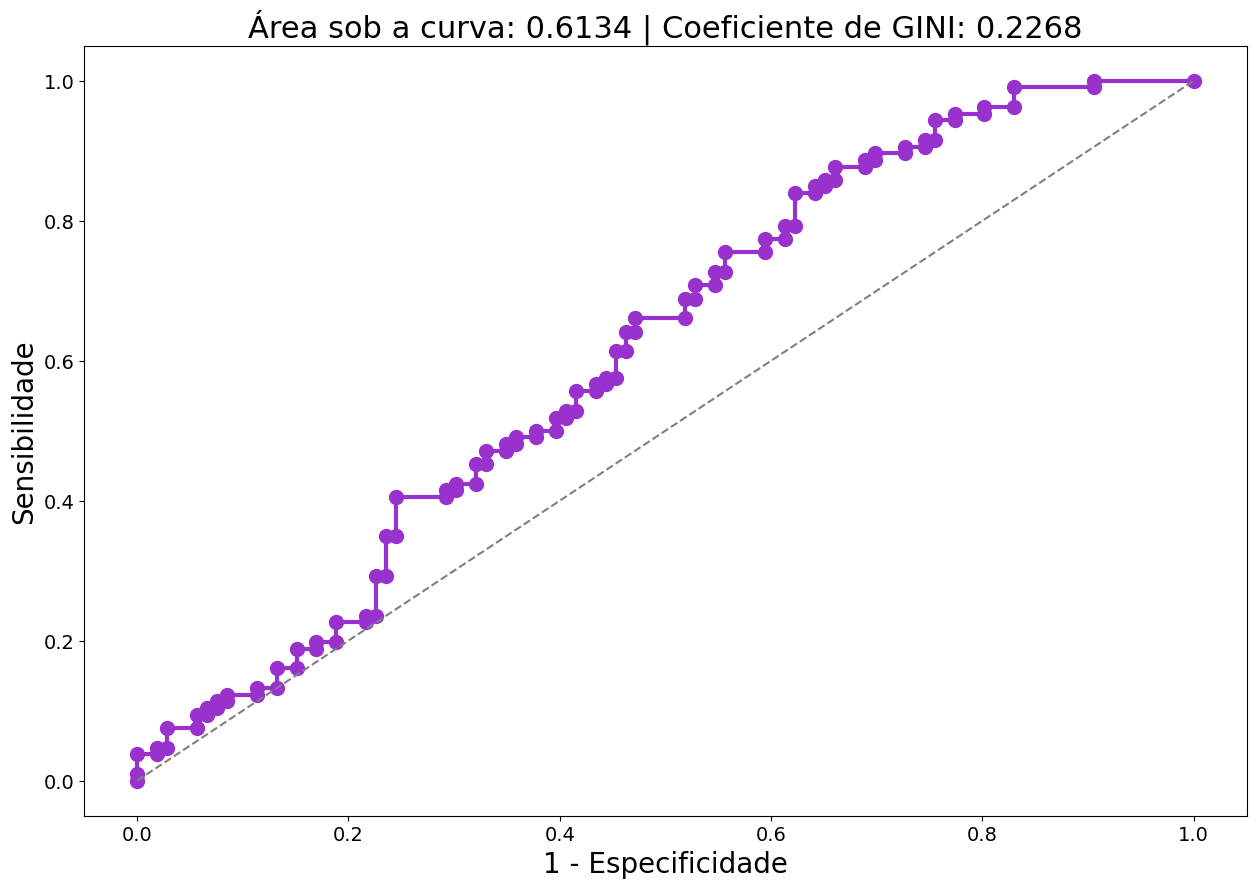

In [ ]:
## Probabilidade de ocorrência do evento (grupo = 1)
base_RL_fatores['previsto'] = modelo_stepwise.predict()

# Análise da curva ROC
# Parametrizando a função da curva ROC (real vs. previsto)
fpr, tpr, thresholds = roc_curve(base_RL_fatores['Gen'], base_RL_fatores['previsto'])
roc_auc = auc(fpr, tpr)

# Cálculo do coeficiente de GINI
gini = (roc_auc - 0.5)/(0.5)

# Plotando a curva ROC
plt.figure(figsize=(15,10))
plt.plot(fpr, tpr, marker='o', color='darkorchid', markersize=10, linewidth=3)
plt.plot(fpr, fpr, color='gray', linestyle='dashed')
plt.title('Área sob a curva: %g' % round(roc_auc, 4) +
          ' | Coeficiente de GINI: %g' % round(gini, 4), fontsize=22)
plt.xlabel('1 - Especificidade', fontsize=20)
plt.ylabel('Sensibilidade', fontsize=20)
plt.xticks(np.arange(0, 1.1, 0.2), fontsize=14)
plt.yticks(np.arange(0, 1.1, 0.2), fontsize=14)
plt.show()

#Análise de Cluster - método hierárquico aglomerativo

## Modelo a partir das variáveis

In [ ]:
#Essa base precisa estar apenas com as variáveis (sem animal e sem grupo)
base_MHA =df[['delta_espessura', 'delta_comprimento', 'delta_quantidade','delta_densidade','delta_temp']]

#Essa base precisa ter a identificação do meu animal
base_MHA_animal =df[['Grupo','delta_espessura', 'delta_comprimento', 'delta_quantidade','delta_densidade','delta_temp']]

#Normalizar as variáveis (Z-score)
variaveis_para_normalizar = ['delta_espessura', 'delta_comprimento', 'delta_quantidade','delta_densidade','delta_temp']
scaler = StandardScaler()
base_MHA[variaveis_para_normalizar] = scaler.fit_transform(base_MHA[variaveis_para_normalizar])

base_MHA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   delta_espessura    23 non-null     float64
 1   delta_comprimento  23 non-null     float64
 2   delta_quantidade   23 non-null     float64
 3   delta_densidade    23 non-null     float64
 4   delta_temp         23 non-null     float64
dtypes: float64(5)
memory usage: 1.0 KB


<ipython-input-235-ad1c4d7f9cae>:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



###Dendrograma

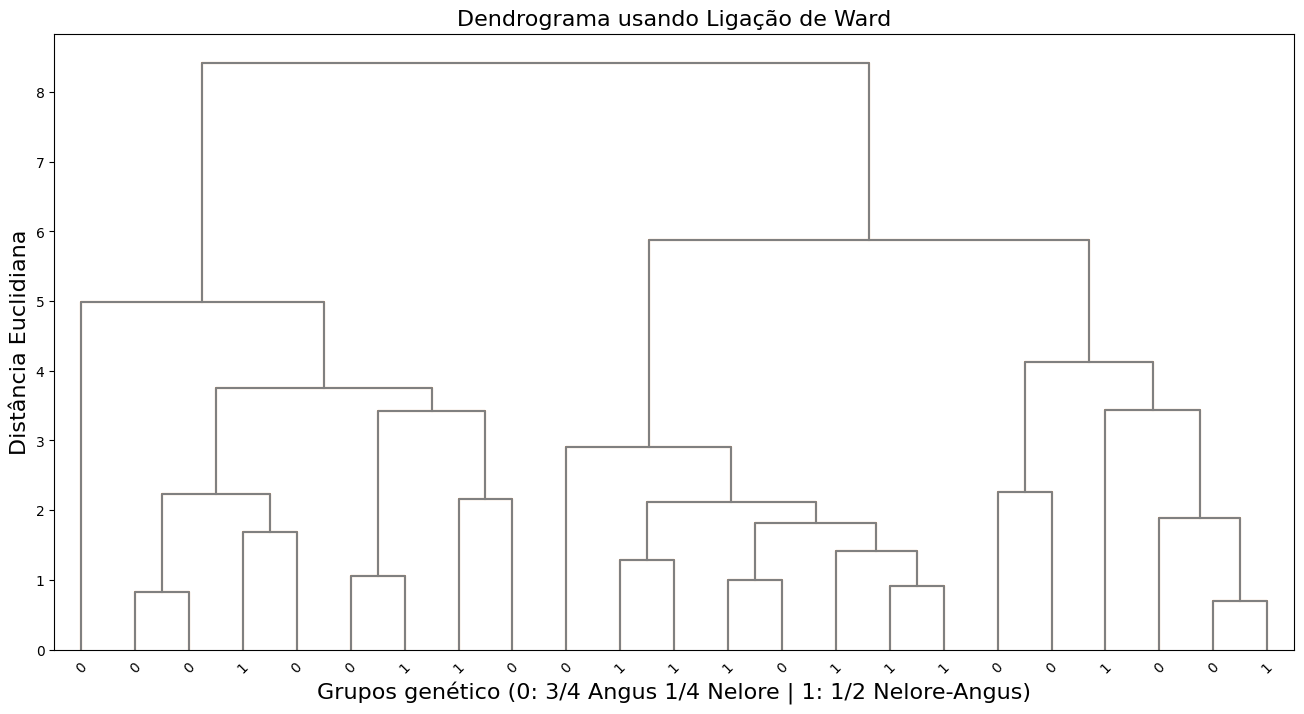

In [ ]:
# Criar a matriz de ligação usando o método Ward e distância euclidiana
dend_ward = sch.linkage(base_MHA, method='ward', metric='euclidean')

# Criar o dendrograma com os rótulos dos grupos
plt.figure(figsize=(16, 8))
dendrogram_s = sch.dendrogram(
 dend_ward,
 color_threshold=60,  # Threshold para colorir os galhos
 labels=base_MHA_animal['Grupo'].values  # Usar os grupos como rótulos na parte inferior
)

# Colorir os galhos com base nos grupos
for i, d, c in zip(dendrogram_s['icoord'], dendrogram_s['dcoord'], dendrogram_s['color_list']):
 x = 0.5 * sum(i[1:3])  # Coordenada x média do galho
 y = d[1]  # Coordenada y do galho
 plt.plot(i, d, color='grey')
 grupo_label = int(base_MHA_animal['Grupo'].iloc[dendrogram_s['leaves'][int(i[0] / 10)]])  # Obter o grupo correspondente

# Adicionar título e rótulos
plt.title('Dendrograma usando Ligação de Ward', fontsize=16)
plt.xlabel('Grupos genético (0: 3/4 Angus 1/4 Nelore | 1: 1/2 Nelore-Angus)', fontsize=16)
plt.ylabel('Distância Euclidiana', fontsize=16)
plt.axhline(y=25, color='red', linestyle='--')  # Linha horizontal para destacar um limite

plt.show()

A ligação de Ward é uma boa opção para amostras pequenas (como nossa amostra), pois evita clusters com alta dispersão ou que sejam muito heterogêneos, tornando os resultados mais confiáveis. Com isso os clusters formados tendem a ser mais compactos e bem definidos (o que evita encadeamento - ou seja, formação de clusters alongados e mal definidos, criados apenas pela menor distância entre os pontos), além de tender a ser menos sensível a outliers.


In [ ]:
# Coeficientes do esquema hierárquico de aglomeração
coef_ward = [y[1] for y in dendrogram_s['dcoord']]
print(coef_ward)

[np.float64(0.8255790533291392), np.float64(1.679250114598519), np.float64(2.236964319862415), np.float64(1.0583891903151537), np.float64(2.1629677969097183), np.float64(3.4263824142637787), np.float64(3.7554061526262648), np.float64(4.981135087913742), np.float64(1.2903422979524315), np.float64(1.0017397346466392), np.float64(0.908223516020875), np.float64(1.4115308760130305), np.float64(1.8212986234856094), np.float64(2.1236175628284073), np.float64(2.9067812355720166), np.float64(2.2668843374820624), np.float64(0.7034008321842768), np.float64(1.8817566902881024), np.float64(3.437048622577089), np.float64(4.118091448333313), np.float64(5.87422567068898), np.float64(8.4158164936205)]


###Método de Elbow - Identificação da quantidade de clusters

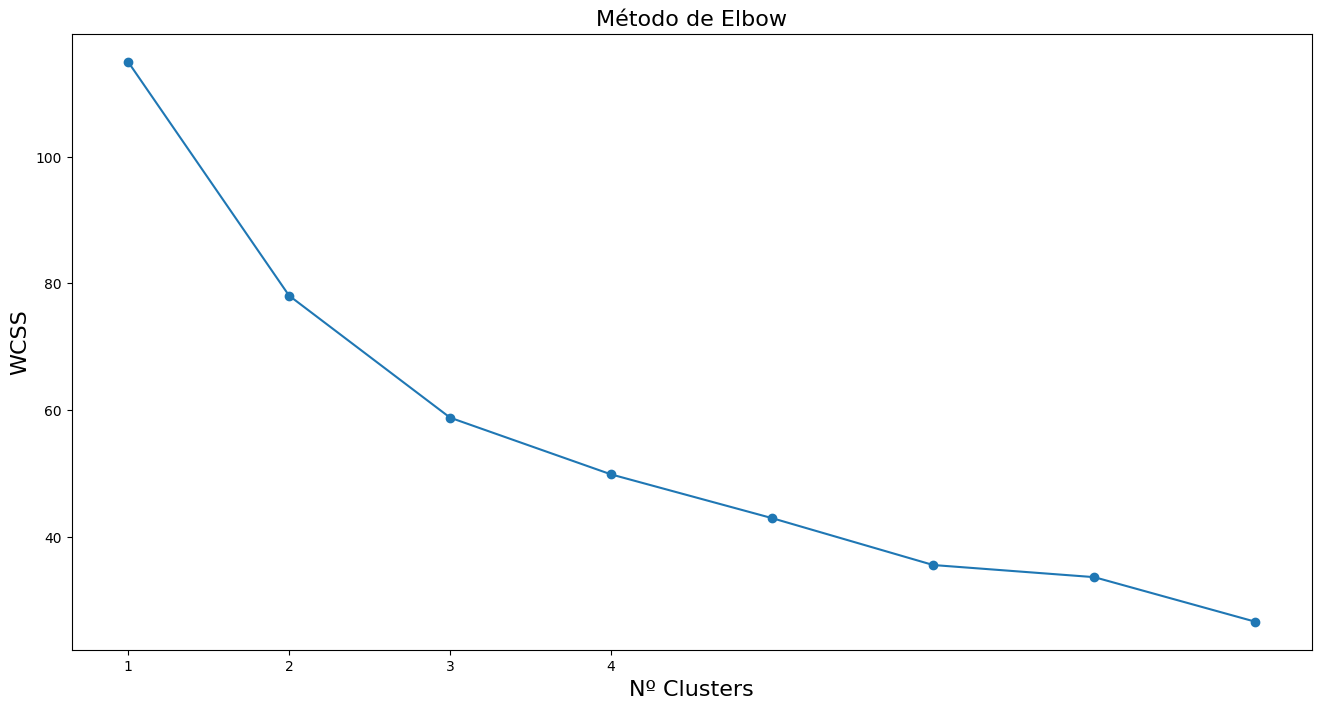

In [ ]:
elbow = []
K = range(1,9) # ponto de parada pode ser parametrizado manualmente
for k in K:
    kmeanElbow = KMeans(n_clusters=k, init='random', random_state=100).fit(base_MHA)
    elbow.append(kmeanElbow.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, elbow, marker='o')
plt.xlabel('Nº Clusters', fontsize=16)
plt.xticks(range(1,5))
plt.ylabel('WCSS', fontsize=16) #Quanto menor o WCSS, mais homogêneos e compactos são os clusters formados
plt.title('Método de Elbow', fontsize=16)
plt.show()

###Clusters

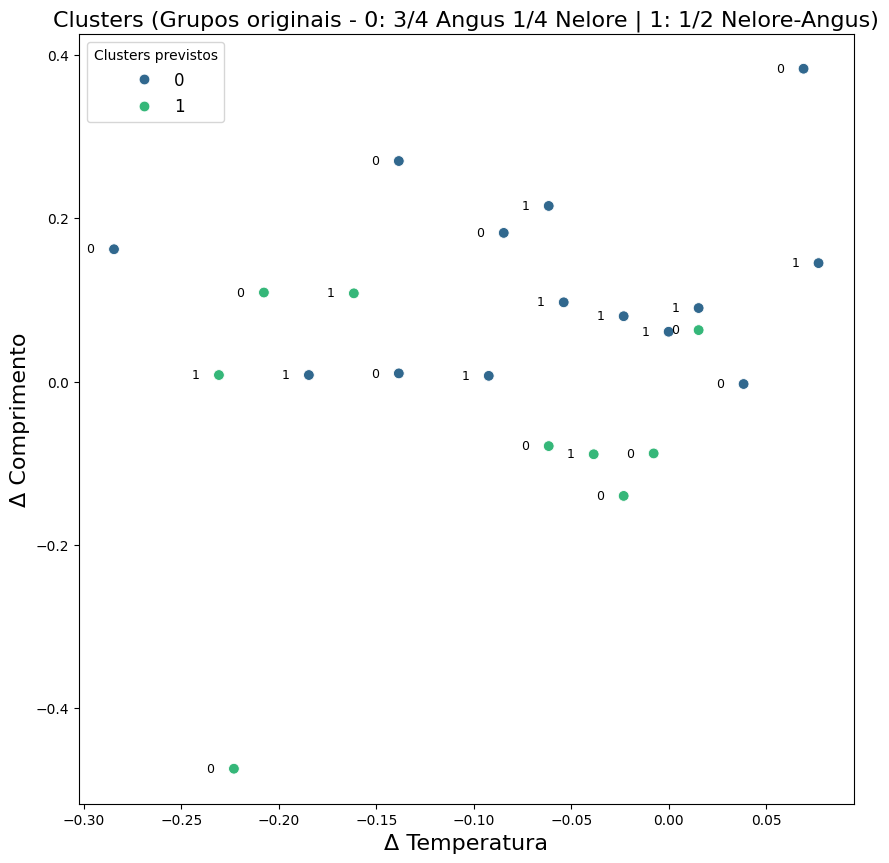

In [ ]:
cluster_ward = AgglomerativeClustering(n_clusters=2, metric='euclidean', linkage='ward') #QUANTIDADE DE CLUSTERS AQUI
indica_cluster = cluster_ward.fit_predict(base_MHA)
base_MHA_animal.loc[:, 'cluster_ward'] = pd.Categorical(indica_cluster)

# Plotando temperatura e comprimento com os clusters previstos usando a paleta viridis
plt.figure(figsize=(10, 10))
fig = sns.scatterplot(x='delta_temp', y='delta_comprimento', s=60, data=base_MHA_animal, hue='cluster_ward', palette='viridis')
plt.title('Clusters (Grupos originais - 0: 3/4 Angus 1/4 Nelore | 1: 1/2 Nelore-Angus)', fontsize=16)  # Título
plt.xlabel('Δ Temperatura', fontsize=16)
plt.ylabel('Δ Comprimento', fontsize=16)
plt.legend(title='Clusters previstos', loc='upper left', fontsize=12)  # Legenda

# Adicionando os rótulos dos grupos verdadeiros ao lado de cada ponto
for i in range(base_MHA_animal.shape[0]):
 plt.text(
     x=base_MHA_animal['delta_temp'].iloc[i] - 0.01,  # Levemente à esquerda (subtraindo 0.1 de x)
     y=base_MHA_animal['delta_comprimento'].iloc[i],  # Mesma altura (y não é alterado)
     s=str(base_MHA_animal['Grupo'].iloc[i]),  # Grupo verdadeiro (0 ou 1)
     fontsize=9, color='black', ha='right', va='center'  # Texto alinhado à direita
 )

plt.show()

Utilizando o Método de Elbow temos a indicação da separação de 2 ou 3 clusters na nossa amostra.  Quando plotamos os clusters gerados, vemos que não há uma separação real entre os animais cujos grupos são originalmente distintos, ressaltando a similaridade entre os grupos.

## Modelo a partir dos fatores

Nessa base nós temos mais animais pois na consolidação anterior foram retirados os animais que não tinham todas as variáveis preenchidas

In [ ]:
#Essa base precisa estar apenas com as variáveis (sem animal e sem grupo)
base_MHA_f = fatores_consolidados[['Fator 1', 'Fator 2', 'Fator 3', 'Fator 4']]

#Essa base precisa ter a identificação do meu animal
base_MHA_animal_f = fatores_consolidados[['Fator 1', 'Fator 2', 'Fator 3', 'Fator 4', 'Gen']]

###Dendrograma

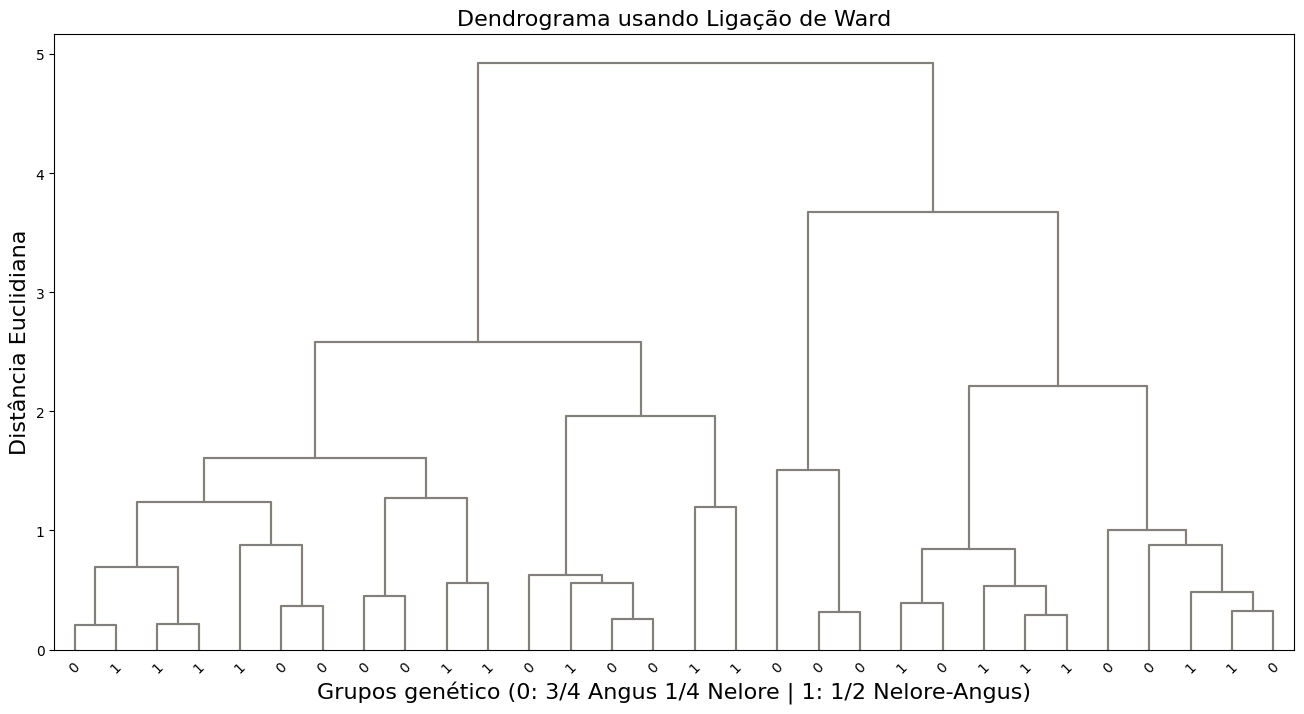

In [ ]:
# Criar a matriz de ligação usando o método Ward e distância euclidiana
dend_ward = sch.linkage(base_MHA_f, method='ward', metric='euclidean')

# Criar o dendrograma com os rótulos dos grupos
plt.figure(figsize=(16, 8))
dendrogram_s = sch.dendrogram(
 dend_ward,
 color_threshold=60,
 labels=base_MHA_animal_f['Gen'].values  # Usar os grupos como rótulos na parte inferior
)

# Colorir os galhos
for i, d, c in zip(dendrogram_s['icoord'], dendrogram_s['dcoord'], dendrogram_s['color_list']):
 x = 0.5 * sum(i[1:3])
 y = d[1]
 plt.plot(i, d, color='grey')  #especificar cor
 grupo_label = int(base_MHA_animal_f['Gen'].iloc[dendrogram_s['leaves'][int(i[0] / 10)]])

# Adicionar título e rótulos
plt.title('Dendrograma usando Ligação de Ward', fontsize=16)
plt.xlabel('Grupos genético (0: 3/4 Angus 1/4 Nelore | 1: 1/2 Nelore-Angus)', fontsize=16)
plt.ylabel('Distância Euclidiana', fontsize=16)
plt.axhline(y=25, color='red', linestyle='--')

plt.show()

###Método de Elbow - Identificação da quantidade de clusters

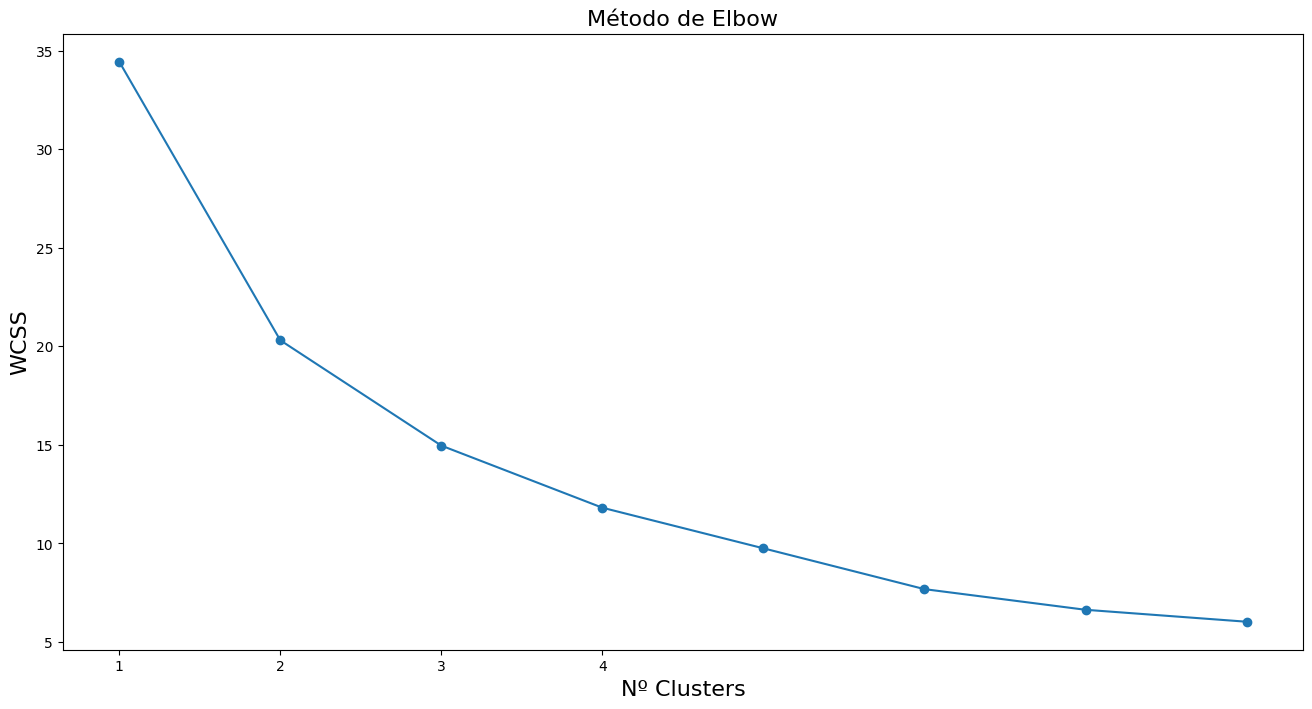

In [ ]:
elbow = []
K = range(1,9) # ponto de parada pode ser parametrizado manualmente
for k in K:
    kmeanElbow = KMeans(n_clusters=k, init='random', random_state=100).fit(base_MHA_f)
    elbow.append(kmeanElbow.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, elbow, marker='o')
plt.xlabel('Nº Clusters', fontsize=16)
plt.xticks(range(1,5))
plt.ylabel('WCSS', fontsize=16)
plt.title('Método de Elbow', fontsize=16)
plt.show()

###Clusters

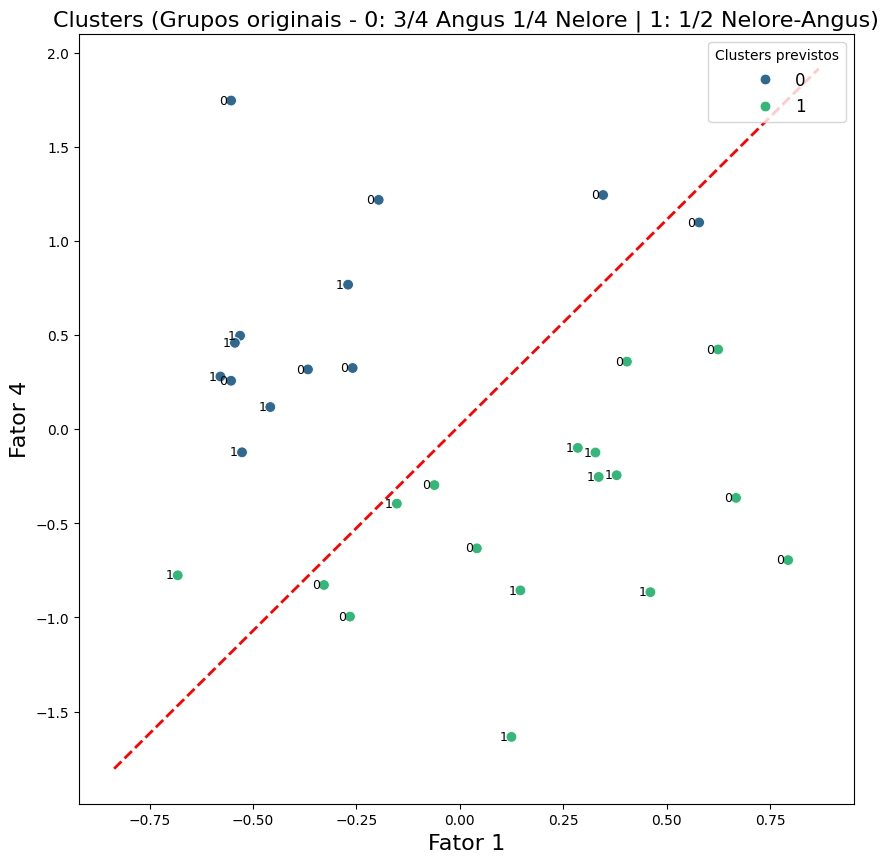

In [ ]:
cluster_ward = AgglomerativeClustering(n_clusters=2, metric='euclidean', linkage='ward') #QUANTIDADE DE CLUSTERS AQUI
indica_cluster = cluster_ward.fit_predict(base_MHA_f)
base_MHA_animal_f.loc[:, 'cluster_ward'] = pd.Categorical(indica_cluster)

# Plotando temperatura e comprimento com os clusters previstos usando a paleta viridis
plt.figure(figsize=(10, 10))
fig = sns.scatterplot(x='Fator 1', y='Fator 4', s=60, data=base_MHA_animal_f, hue='cluster_ward', palette='viridis')
plt.title('Clusters (Grupos originais - 0: 3/4 Angus 1/4 Nelore | 1: 1/2 Nelore-Angus)', fontsize=16)  # Título
plt.xlabel('Fator 1', fontsize=16)
plt.ylabel('Fator 4', fontsize=16)
plt.legend(title='Clusters previstos', loc='upper right', fontsize=12)  # Legenda

# Adicionando os rótulos dos grupos verdadeiros ao lado de cada ponto
for i in range(base_MHA_animal_f.shape[0]):
 plt.text(
     x=base_MHA_animal_f['Fator 1'].iloc[i] - 0.01,
     y=base_MHA_animal_f['Fator 4'].iloc[i],
     s=str(base_MHA_animal_f['Gen'].iloc[i]),
     fontsize=9, color='black', ha='right', va='center'
 )

# Adicionando uma linha diagonal ajustável
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
plt.plot([x_min-0.08, x_max], [y_min, y_max], color='red', linestyle='--', linewidth=2)  # Linha diagonal em vermelho

plt.show()

Utilizando o Método de Elbow claramente há indicação de 2 cluster, que na plotagem dos fatores 1 e 4 (sendo o 1 escolhido por capturar a maior proporção da variabilidade total presente nas variáveis originais e o 4 por ter apresentado significância no modelo de regressão logística).

No plot vemos a diferenciação clara de dois clusters. Ao passar uma linha diagonal no plot, vemos que parte dos pontos de um cluster fica na parte superior da linha e os demais indivíduos na parte inferior. Entretanto, quando observamos o grupo original de cada um desses animais dentro dos clusters, mais uma vez verificamos a semelhança entre os grupos genéticos, sendo os clusters bem definidos preditos provavelmente oriundos da individualidade de cada animal, não sendo o grupo genético a origem dessas diferenças.

#Análise de Componentes Principais (PCA)

###Base de dados

In [ ]:
#df.info()
PCA_completa = df[['animal_gen','Grupo','espessura_4','comprimento_4','quantidade_4','densidade_4','delta_temp']]
PCA_variaveis=df[['espessura_4','comprimento_4','quantidade_4','densidade_4','delta_temp']]


# Normalizar as variáveis (Min-Max Scaling)
variaveis_para_normalizar = list(PCA_variaveis.columns)
scaler = MinMaxScaler()  # Criar o objeto MinMaxScaler
PCA_variaveis[variaveis_para_normalizar] = scaler.fit_transform(PCA_variaveis[variaveis_para_normalizar])

<ipython-input-95-39b0607c7f5f>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Análise PCA

In [ ]:
# Reduzindo para 2 componentes principais
pca = PCA(n_components=2)
df_pca = pd.DataFrame(pca.fit_transform(PCA_variaveis), columns=['PC1', 'PC2'], index=PCA_variaveis.index)
df_pca['Grupo'] = PCA_completa['Grupo']

df_pca.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PC1     23 non-null     float64
 1   PC2     23 non-null     float64
 2   Grupo   23 non-null     int64  
dtypes: float64(2), int64(1)
memory usage: 684.0 bytes


#### Análise dos Pesos das Variáveis nos Compontens Principais (Loadings do PCA)

In [ ]:
loadings = pca.components_
loadings_df = pd.DataFrame(loadings.T, index=PCA_variaveis.columns, columns=['PC1', 'PC2'])
print("Loadings do PCA:\n", loadings_df)

Loadings do PCA:
                     PC1       PC2
espessura_4    0.766098 -0.049832
comprimento_4  0.057275  0.915038
quantidade_4  -0.472420  0.037517
densidade_4   -0.432010 -0.008789
delta_temp    -0.000766  0.398418


**PC1:** Relacionado a alta espessura e inversamente relacionada à quantidade e densidade, ou seja, amostras com alta espessura tendem a ter menor quantidade e densidade.

**PC2:** Relacionado principalmente ao comprimento e Δ temperaura (ambos positivamente).

###Método de Elbow - Identificação da quantidade de clusters

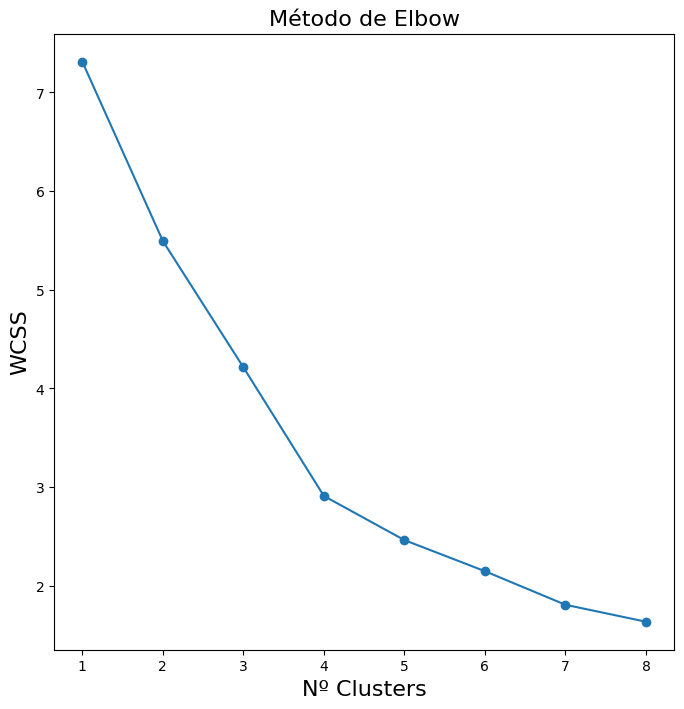

In [ ]:
## Normalmente, busca-se o "cotovelo", ou seja, o ponto onde a curva "dobra"
elbow = []
K = range(1,9) # ponto de parada pode ser parametrizado manualmente
for k in K:
    kmeanElbow = KMeans(n_clusters=k, init='random', random_state=100).fit(PCA_variaveis)
    elbow.append(kmeanElbow.inertia_)

plt.figure(figsize=(8,8))
plt.plot(K, elbow, marker='o')
plt.xlabel('Nº Clusters', fontsize=16)
plt.xticks(range(1,9))
plt.ylabel('WCSS', fontsize=16)
plt.title('Método de Elbow', fontsize=16)
plt.show()

### Gráfico de dispersão (PCA) - Colorido de acordo com o Grupo

0 = 3/4 Angus 1/4 Nelore  (azul)

1 = 1/2 Nelore-Angus      (vermelho)


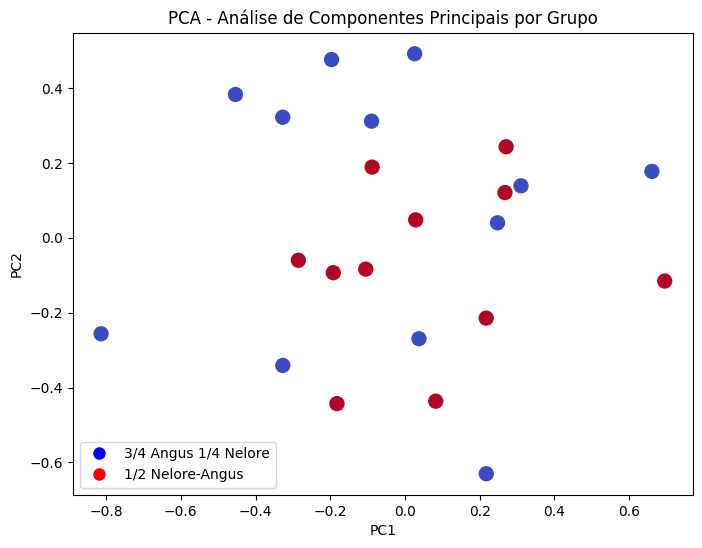

In [ ]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(df_pca['PC1'], df_pca['PC2'], c=df_pca['Grupo'], cmap='coolwarm', s=100)

#  legenda
legend_elements = [
  Line2D([0], [0], marker='o', color='w', label='3/4 Angus 1/4 Nelore',
         markerfacecolor='blue', markersize=10),
  Line2D([0], [0], marker='o', color='w', label='1/2 Nelore-Angus',
         markerfacecolor='red', markersize=10)
]
plt.legend(handles=legend_elements, loc='lower left')

plt.title('PCA - Análise de Componentes Principais por Grupo')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

Observando os grupos originais, parece que o vermelho está inserido de forma mais concentrado dentro do azul, mais disperso.

#### Funções que vou utilizar embaixo

In [ ]:
# Função para categorizar com base nos limites dos quartis
def categorizar(valor, limites):
 if valor < limites[0]:
     return "Muito Baixa"
 elif valor < limites[1]:
     return "Baixa"
 elif valor < limites[2]:
     return "Moderada"
 else:
     return "Alta"

# Função principal para calcular categorias automaticamente
def calcular_categorias_por_cluster(medias_por_cluster, variaveis):
 categorias_por_cluster = {}

 # Calculando os quartis para cada variável
 quartis = PCA_variaveis.quantile([0.25, 0.5, 0.75])

 # Iterar sobre cada variável
 for variavel in variaveis:
     limites = [quartis.loc[0.25, variavel], quartis.loc[0.5, variavel], quartis.loc[0.75, variavel]]

     # Categorizar os valores médios dos clusters para a variável atual
     categorias_por_cluster[variavel] = medias_por_cluster[variavel].apply(lambda x: categorizar(x, limites))

 return pd.DataFrame(categorias_por_cluster)

variaveis_originais = PCA_variaveis.columns

### Clustering Hierárquico.

Agrupa os dados em clusters com base na similaridade entre as observações.

 Ele é uma técnica de aprendizado não supervisionado que organiza os dados em grupos com base em padrões e similaridades nos próprios dados (não é uma previsão no sentido tradicional).

 Plota os dados em cima do PC1 e PC2 - gerado na PCA

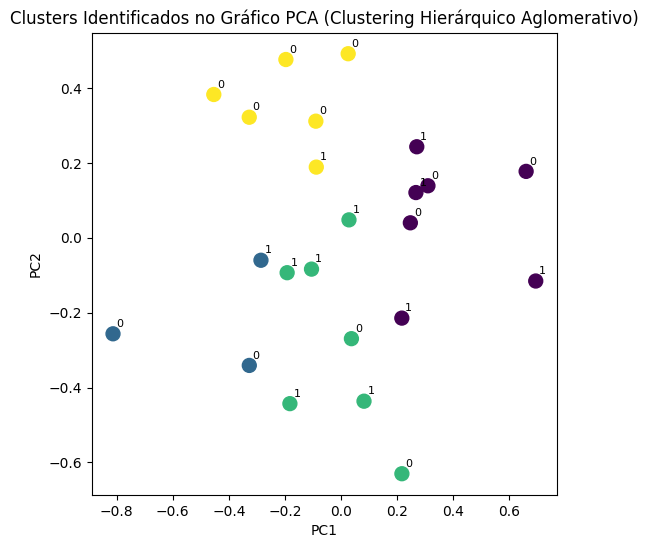

In [ ]:
# Aplicando o Cluster Hierárquico
cluster_ward = AgglomerativeClustering(n_clusters=4, metric='euclidean', linkage='ward')
df_pca['Cluster_Ward'] = cluster_ward.fit_predict(PCA_variaveis)

plt.figure(figsize=(6, 6))
plt.scatter(df_pca['PC1'], df_pca['PC2'], c=df_pca['Cluster_Ward'], cmap='viridis', s=100)

for i in range(len(df_pca)):
 plt.annotate(str(df_pca['Grupo'][i]),
              (df_pca['PC1'][i], df_pca['PC2'][i]),
              textcoords="offset points",
              xytext=(5, 5),
              ha='center', fontsize=8)

plt.title('Clusters Identificados no Gráfico PCA (Clustering Hierárquico Aglomerativo)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

#### Analisando a média das variáveis em cada cluster

In [ ]:
df_pca['Cluster_Ward'] = df_pca['Cluster_Ward'].astype(int) # garantindo o formato
PCA_variaveis = PCA_variaveis.apply(pd.to_numeric, errors='coerce')

# Calcular as médias por cluster (CHA)
medias_por_cluster_CHA = PCA_variaveis.groupby(df_pca['Cluster_Ward']).mean()
print("\nMédias das Variáveis Originais por Cluster (CHA):\n", medias_por_cluster_CHA)


Médias das Variáveis Originais por Cluster (CHA):
               espessura_4  comprimento_4  quantidade_4  densidade_4  \
Cluster_Ward                                                          
0                0.826087       0.707553      0.263320     0.297408   
1                0.159420       0.525273      0.654054     0.647084   
2                0.484472       0.252342      0.379151     0.424392   
3                0.333333       0.899932      0.508559     0.498657   

              delta_temp  
Cluster_Ward              
0               0.504559  
1               0.120567  
2               0.674772  
3               0.751773  


#### Categorizando as variáveis em cada cluster

In [ ]:
categorias_CHA = calcular_categorias_por_cluster(medias_por_cluster_CHA, variaveis_originais)
print("\nCategorias das Variáveis por Cluster (CHA):\n", categorias_CHA)


Categorias das Variáveis por Cluster (CHA):
               espessura_4 comprimento_4 quantidade_4  densidade_4   delta_temp
Cluster_Ward                                                                  
0                    Alta      Moderada  Muito Baixa  Muito Baixa        Baixa
1             Muito Baixa         Baixa         Alta         Alta  Muito Baixa
2                Moderada   Muito Baixa        Baixa        Baixa     Moderada
3                   Baixa          Alta         Alta         Alta     Moderada


### KMeans para identificar grupos

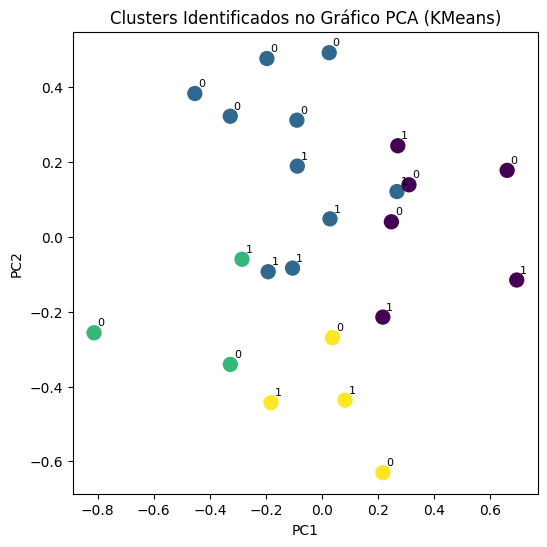

In [ ]:
# Aplicando o K-means
kmeans = KMeans(n_clusters=4, random_state=111)  # Fixando random_state para que a iniciação do centróide (que ocorre de forma "aleatória" pare de mudar)
df_pca['Cluster'] = kmeans.fit_predict(PCA_variaveis)

plt.figure(figsize=(6, 6))
plt.scatter(df_pca['PC1'], df_pca['PC2'], c=df_pca['Cluster'], cmap='viridis', s=100)

for i in range(len(df_pca)):
 plt.annotate(str(df_pca['Grupo'][i]),
              (df_pca['PC1'][i], df_pca['PC2'][i]),
              textcoords="offset points",
              xytext=(5, 5),
              ha='center', fontsize=8)

plt.title('Clusters Identificados no Gráfico PCA (KMeans)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

Os cluster encontrados por Clusterização Aglomerativa e Kmeans diferem pois o K-Means tenta dividir os dados em k clusters minimizando a soma das distâncias quadradas entre os pontos e o centroide de cada cluster, enquanto a Clusterização Aglomerativa constrói os clusters progressivamente combinando os clusters mais próximos com base na métrica de distância.

O Kmeans se baseia no centróide (atribui cada ponto ao cluster cujo centroide está mais próximo e atualiza os centróides com base na média dos pontos atribuídos a cada cluster), o Cluster Aglomerativo não assume que os clusters têm formas esféricas, podendo lidar melhor com clusters de formas irregulares.

#### Analisando a média das variáveis em cada cluster

In [ ]:
df_pca['Cluster'] = df_pca['Cluster'].astype(str)
medias_por_cluster_kmeans = PCA_variaveis.groupby(df_pca['Cluster']).mean()
print("\nMédias das Variáveis Originais por Cluster (K-Means):\n", medias_por_cluster_kmeans)


Médias das Variáveis Originais por Cluster (K-Means):
          espessura_4  comprimento_4  quantidade_4  densidade_4  delta_temp
Cluster                                                                   
0           0.818841       0.732240      0.234234     0.275891    0.421986
1           0.404348       0.731557      0.465405     0.475367    0.785106
2           0.159420       0.525273      0.654054     0.647084    0.120567
3           0.554348       0.102459      0.372297     0.408882    0.595745


#### Categorizando as variáveis em cada cluster

In [ ]:
medias_por_cluster_KMeans = PCA_variaveis.groupby(df_pca['Cluster']).mean()
categorias_KMeans = calcular_categorias_por_cluster(medias_por_cluster_KMeans, variaveis_originais)
print("\nCategorias das Variáveis por Cluster (K-Means):\n", categorias_KMeans)


Categorias das Variáveis por Cluster (K-Means):
          espessura_4 comprimento_4 quantidade_4  densidade_4   delta_temp
Cluster                                                                  
0               Alta      Moderada  Muito Baixa  Muito Baixa        Baixa
1              Baixa      Moderada     Moderada     Moderada         Alta
2        Muito Baixa         Baixa         Alta         Alta  Muito Baixa
3           Moderada   Muito Baixa        Baixa        Baixa        Baixa


# Explorando as clusterizações

## Comparando os métodos

### Método da silhueta (Silhouette Score)

Score mais alto indica clusters mais bem definidos.


In [ ]:
# Silhouette Score para CHA
silhouette_cha = silhouette_score(PCA_variaveis, df_pca['Cluster_Ward'])
print("Silhouette Score (CHA):", silhouette_cha)

# Silhouette Score para K-Means
silhouette_kmeans = silhouette_score(PCA_variaveis, df_pca['Cluster'])
print("Silhouette Score (K-Means):", silhouette_kmeans)

Silhouette Score (CHA): 0.27064865434794827
Silhouette Score (K-Means): 0.2433008103555102


### Soma das Distâncias Quadradas Internas ao Cluster (*Within-Cluster Sum of Squares* - WCSS )

Avaliação de qualidade dos clusters - geralmente usado para o K-Means.Mede a soma das distâncias quadradas entre cada ponto e o centróide do cluster ao qual pertence.

WCSS menor indica que os pontos estão mais próximos de seus centróides, o que geralmente significa clusters mais compactos.

Como os algoritmos tem abordagens diferentes, o WCSS de cada um difere entre si.

O objetivo principal do K-Means é minimizar diretamente o WCSS enquanto o CHA forma clusters com base na proximidade hierárquica entre os pontos, não otimizando o WCSS diretamente.

In [ ]:
#Como no CHA o WCSS não é uma preocupação, precisamos calcular as distâncias dos pontos aos centróides dos clusters formados no final do processo.
centroids_cha = []
for cluster in np.unique(df_pca['Cluster_Ward']):
 cluster_points = PCA_variaveis[df_pca['Cluster_Ward'] == cluster]  # Pontos do cluster atual
 centroid = cluster_points.mean(axis=0)  # Média dos pontos no cluster
 centroids_cha.append(centroid)

wcss_cha = 0
for cluster, centroid in zip(np.unique(df_pca['Cluster_Ward']), centroids_cha):
 cluster_points = PCA_variaveis[df_pca['Cluster_Ward'] == cluster]
 wcss_cha += np.sum((cluster_points - centroid)**2)

wcss_cha_total = wcss_cha.sum(axis=0)
print("WCSS Total (CHA):", wcss_cha_total)

wcss_kmeans = kmeans.inertia_
print("WCSS (K-Means):", wcss_kmeans)

WCSS Total (CHA): 2.97115943168989
WCSS (K-Means): 3.0579480783525144


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:84: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)



Normalmente os clusters formados pelo CHA tendem a ser irregulares, o que leva a WCSS maiores. É também esperado um valor menor de WCSS do K-Means pois esse possui otimização diretamente relacionada a essa métrica durante sua construção. Entretanto na nossa base **os clusters formados pelo CHA demonstraram menor valor de WCSS**, o que pode indicar que o CHA está capturando melhor a estrutura dos dados, formando clusters ligeiramente mais compactos.

In [ ]:
import pandas as pd
from scipy.spatial.distance import euclidean

# Supondo que você já tem as médias por cluster calculadas:
# medias_por_cluster_KMeans: DataFrame com médias das variáveis por cluster (K-Means)
# medias_por_cluster_CHA: DataFrame com médias das variáveis por cluster (CHA)

# Função para encontrar clusters mais semelhantes
def comparar_clusters(medias_kmeans, medias_cha):
  similaridade = {}

  for cluster_kmeans in medias_kmeans.index:
      distancias = []
      for cluster_cha in medias_cha.index:
          # Calculando a distância euclidiana entre os clusters
          distancia = euclidean(medias_kmeans.loc[cluster_kmeans], medias_cha.loc[cluster_cha])
          distancias.append((cluster_cha, distancia))

      # Encontrar o cluster CHA mais próximo do cluster K-Means atual
      cluster_mais_proximo = min(distancias, key=lambda x: x[1])
      similaridade[cluster_kmeans] = cluster_mais_proximo

  return similaridade

  # Comparar os clusters
similaridade_clusters = comparar_clusters(medias_por_cluster_KMeans, medias_por_cluster_CHA)

  # Exibir resultados
print("\nCorrespondência entre clusters do K-Means e CHA:")
for cluster_kmeans, (cluster_cha, distancia) in similaridade_clusters.items():
  print(f"Cluster {cluster_kmeans} (K-Means) ↔ Cluster {cluster_cha} (CHA) | Distância: {distancia:.4f}")


Correspondência entre clusters do K-Means e CHA:
Cluster 0 (K-Means) ↔ Cluster 3 (CHA) | Distância: 0.1684
Cluster 1 (K-Means) ↔ Cluster 2 (CHA) | Distância: 0.0590
Cluster 2 (K-Means) ↔ Cluster 1 (CHA) | Distância: 0.1684
Cluster 3 (K-Means) ↔ Cluster 0 (CHA) | Distância: 0.0938


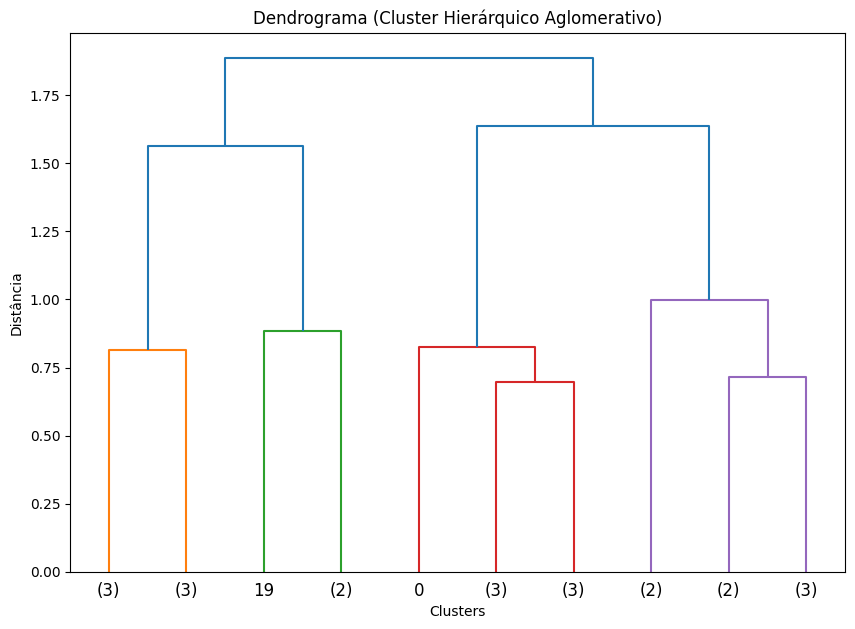

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage

# Gerar o dendrograma
linkage_matrix = linkage(PCA_variaveis, method='ward')
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix, truncate_mode='lastp', p=10, show_leaf_counts=True)
plt.title('Dendrograma (Cluster Hierárquico Aglomerativo)')
plt.xlabel('Clusters')
plt.ylabel('Distância')
plt.show()

##Análise das Médias das Variáveis Originais por Cluster

**Cluster 0 (roxo):** amostras com alto comprimento, mas baixa espessura, e valores intermediários para densidade e quantidade. Grupo com características mais alongadas e menos densas. Moderado delta de temperatura.

**Cluster 1 (verde):** amostras com alta espessura, mas baixa densidade e quantidade. Grupo com características mais grossas, mas menos concentradas ou abundantes.

**Cluster 2 (amarelo):** amostras com menor comprimento, mas intermediária espessura, densidade e quantidade, e maior delta de temperatura. Pode representar um grupo com características mais compactas e variabilidade térmica mais alta.

